# Walker Advertising Starter Code

In this code, you will be diving into modern time series tools. We will be looking at a data set of calls coming into a call center.

In [ ]:
!pip install fbprophet --upgrade

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fbprophet import Prophet

import math

Importing plotly failed. Interactive plots will not work.


In [2]:
# This sets some nicer defaults for plotting.
# This must be run in a separate cell from importing matplotlib due to a bug.
params = {'legend.fontsize': 'large',
          'figure.figsize': (11.0, 11.0),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
mpl.rcParams.update(params)

# This makes it so that the pandas dataframes don't get truncated horizontally.
pd.options.display.max_columns = 200

## Import and Explore the Data

Our first data set is going to be a data set of call into the call center over time.

In [3]:
df_calls = pd.read_csv("CallsTable.zip")

In [4]:
df_calls.head()

CallId    StartTime          City State  Area CompanyShortName LawType  \
0  1824011  1/1/17 3:10   CHATTANOOGA    TN    TN               LD     L&E   
1  1824012  1/1/17 4:39        NOCONA    TX   TX2               LD    Misc   
2  1824013  1/1/17 6:07    ROSEFIELD     VA    VA              TL2    Misc   
3  1824014  1/1/17 6:24      PALM BAY    FL    FL              TL2    Misc   
4  1824019  1/1/17 7:29  GAINESVILLE     GA  GA11              TL2    Misc   

         MediaSource   MediaGroup    WeekOf  
0  losdefensores.com  Traditional  12/26/16  
1  losdefensores.com  Traditional  12/26/16  
2            Digital      Digital  12/26/16  
3     ORGANIC SEARCH  Traditional  12/26/16  
4     ORGANIC SEARCH  Traditional  12/26/16

In [5]:
df_calls.shape

(332530, 10)

Every row is a call. You can also see that we have a bunch of information about the call. Since this is a time series, we will need to convert the `StartTime` and `WeekOf` variables into `datetime` types.

In [6]:
df_calls['StartTime'] = pd.to_datetime(df_calls['StartTime'])

In [7]:
df_calls['WeekOf'] = pd.to_datetime(df_calls['WeekOf'])

## Split the Data into Training and Testing

Unlike cross-sectional data, we can't just split the data randomly. Time series prediction challenges are fundamentally about predicting the future, and our out of sample testing procedure needs to reflect that. Therefore, we have to split on time. Our training data set needs to precede our testing data set. To do this, we will hold out the last two months of data as a testing data set.

First let's get the last date of `df_calls`.

In [8]:
df_calls['StartTime'] = pd.to_datetime(df_calls['StartTime'])

This means that we need to use everything after October 31st, 2018 as the testing set.

In [9]:
training_cutoff = pd.to_datetime('2018-11-1 00:00:00')

Now we have a value we can use to divide the training and the test sets. However, first we need to do some more data preprocessing.

## Initial Data Analysis

Right now, we have a list of calls. What we really care about is call volume. That will require us to aggregate the data over some period of time. We will create two new variables, `StartTimeHourly` and `StartTimeDaily` that will allow us to aggregate by hours and by days, respectively. We will create these variables by using the `.apply()` method of a `DataFrame`. `.apply()` allows us to do the same operation on all of the rows of a `DataFrame`.

We will use a "lambda" function as the input to the `.apply()` method. A lambda function is a way to define a function (which we've seen plenty of times before) without giving it a name. Below, we use `lambda dt: dt.replace(minute=0)`. Let's unpack this. `lambda` means we are defining a lambda function. `dt` is the name of the input to the function. Normally we would write something like `def whatever(dt)` when writing a function, and `dt` would be the variable for that function. The lambda function is the same, but we are just calling the variable `dt`. Then everything else is the function. In this case `dt.replace(minute=0)` is calling the `.replace()` method on the `datetime` object. This is a special function for `datetime` objects which can replace parts of the datetime. In this case, we replace the minute with `0`, which effectively makes all timestamps be on the hour.

In [10]:
df_calls['StartTimeHourly'] = df_calls['StartTime'].apply(lambda dt: dt.replace(minute=0))

Now we need some way to count the number of calls in each time period. We will do this using the `.groupby()` method. This is a very useful `DataFrame` method that allows you to work on groups of rows at a time. We will `.groupby()` the time period we are interested in. Once we have things grouped, we can do things like count how many things there are in that group. We will do this with the `.count()` method.

In [11]:
df_calls.groupby(['StartTimeHourly'])['CallId'].count()

StartTimeHourly
2017-01-01 03:00:00    1
2017-01-01 04:00:00    1
2017-01-01 06:00:00    2
2017-01-01 07:00:00    3
2017-01-01 08:00:00    5
                      ..
2018-12-30 18:00:00    8
2018-12-30 19:00:00    2
2018-12-30 20:00:00    3
2018-12-30 21:00:00    4
2018-12-30 23:00:00    1
Name: CallId, Length: 16639, dtype: int64

In [12]:
df_calls_grouped_hourly = df_calls.groupby(['StartTimeHourly'])['CallId'].count()

This is almost what we are looking for, but not quite. It turns out that Walker Advertising does not get a call every hour of the day, so our dataset has gaps in it. Most time series methods really like regular data, and we know if we don't have any calls, then the number of calls should be 0 (i.e., we don't have a missing data problem, just an irregular data problem).

To fix this, we will create a time series of all zeros, and then we will fill in the hours for which Walker Advertising received calls. We can do that by first creating a range of dates, and then creating a time series dataframe.

In [13]:
dates = pd.date_range(start=pd.to_datetime('2017-01-01 00:00:00'), end=pd.to_datetime('2018-12-30 23:00:00'), freq='H')

The time series method we are going to use requires that we have a very specific structure for our `DataFrame`. It needs to have two columns. One needs to be called "ds" and it should be the timestamp associated with the record. The other column should be called `y`, and it should have the value for the record.

The easiest way to define a `DataFrame` is to use the `pd.DataFrame` function and give it a "dictionary" where the keys are the column names and the values are the rows. In this case, this looks like the below.

In [14]:
ts_hourly = pd.DataFrame({'ds': dates, 'y': np.zeros(len(dates))})

We will temporarily need to set the index of `ts_hourly` to the `ds` row so that we can access the rows with the indices of `df_calls_grouped_hourly`.

In [15]:
ts_hourly = ts_hourly.set_index('ds')

In [16]:
# ts_hourly

Now, we can use the `.loc` method to access all of the indices that correspond to the hours we've received calls and then set those values equal to the number of calls we received.

In [17]:
ts_hourly['y'].loc[df_calls_grouped_hourly.index] = df_calls_grouped_hourly

Now we can reset the index, which will be necessary for our forecasting method.

In [18]:
ts_hourly = ts_hourly.reset_index()

In [19]:
ts_hourly

ds    y
0     2017-01-01 00:00:00  0.0
1     2017-01-01 01:00:00  0.0
2     2017-01-01 02:00:00  0.0
3     2017-01-01 03:00:00  1.0
4     2017-01-01 04:00:00  1.0
...                   ...  ...
17491 2018-12-30 19:00:00  2.0
17492 2018-12-30 20:00:00  3.0
17493 2018-12-30 21:00:00  4.0
17494 2018-12-30 22:00:00  0.0
17495 2018-12-30 23:00:00  1.0

[17496 rows x 2 columns]

Now we need to split this data set up into a training and a test set.

In [20]:
ts_hourly_train = ts_hourly.loc[ts_hourly['ds'] < training_cutoff].copy()
ts_hourly_test = ts_hourly.loc[ts_hourly['ds'] >= training_cutoff].copy()

In [21]:
len(ts_hourly_train)

16056

In [22]:
len(ts_hourly_test)

1440

We will also find it useful to look at the data on a weekly basis. We will use the `WeekOf` variable because it is very common in the advertising industry to measure things from the Monday of the week. Notice that I'm skipping the first and last weeks (with the indexing `[1:-1]`) because the first and last weeks are not entire weeks.

Let's try plotting out data to see what this series looks like. Let's start by looking at the hourly series.

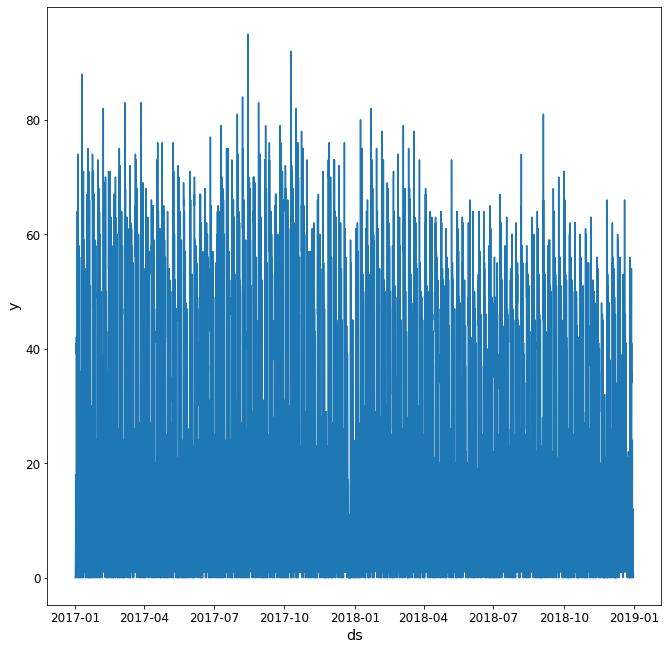

In [23]:
sns.lineplot(x='ds', y='y', data=ts_hourly)
plt.show()

Well, that's not very easy to read. It seems like we are taking too fine of a cut of the data to see too much useful. Our forecast will maybe help clear things up.

## Time Series Forecasting for Fun and Prophet

We are going to use a time series forecasting tool developed by Facebook called Prophet. Prophet is intended to be a very easy to use and flexible time series tool that automates a lot of the standard work around time series forecasting.

We will forecast calls on an hourly basis, but we could always aggregate up to forecast on a daily, weekly, or monthly basis as well. This is call center data, and the volume of calls to a call center often change on a holiday. Prophet makes it very easy to include country specific holidays. Below we fit the time series model.

In [24]:
m_hourly = Prophet()
m_hourly.add_country_holidays(country_name='US')
m_hourly.fit(ts_hourly_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


We will now forecast out two months (through the training set). In order to do this, we have to make a `future` dataframe. We tell it we want `24*60` periods (since we are forecasting hourly, we need 24 periods for each day), and we want it to give us periods every hour, so we specify `freq='H'`.

In [25]:
future = m_hourly.make_future_dataframe(periods=24*60, freq='H')

Now we can predict.

In [26]:
forecast = m_hourly.predict(future)

After we predict, we can see the components of the forecast by looking at the `forecast` dataframe.

In [27]:
forecast

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0     2017-01-01 00:00:00  20.059238  -23.500368   -0.565499    20.059238   
1     2017-01-01 01:00:00  20.059998  -23.334262   -0.900511    20.059998   
2     2017-01-01 02:00:00  20.060757  -24.100077   -1.643774    20.060757   
3     2017-01-01 03:00:00  20.061517  -24.793559   -1.941940    20.061517   
4     2017-01-01 04:00:00  20.062277  -22.857849   -0.827276    20.062277   
...                   ...        ...         ...         ...          ...   
17491 2018-12-30 19:00:00  17.713934   -6.917820   16.819020    16.782332   
17492 2018-12-30 20:00:00  17.713975  -10.266150   13.091983    16.781941   
17493 2018-12-30 21:00:00  17.714015  -11.281583   11.924342    16.781550   
17494 2018-12-30 22:00:00  17.714056  -13.180701   10.684616    16.781159   
17495 2018-12-30 23:00:00  17.714096  -13.348854   10.026003    16.780768   

       trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0        20.059238            0.0                  0.0                  0.0   
1        20.059998            0.0                  0.0                  0.0   
2        20.060757            0.0                  0.0                  0.0   
3        20.061517            0.0                  0.0                  0.0   
4        20.062277            0.0                  0.0                  0.0   
...            ...            ...                  ...                  ...   
17491    18.630661            0.0                  0.0                  0.0   
17492    18.632506            0.0                  0.0                  0.0   
17493    18.634352            0.0                  0.0                  0.0   
17494    18.636198            0.0                  0.0                  0.0   
17495    18.638043            0.0                  0.0                  0.0   

       Columbus Day  Columbus Day_lower  Columbus Day_upper  Independence Day  \
0               0.0                 0.0                 0.0               0.0   
1               0.0                 0.0                 0.0               0.0   
2               0.0                 0.0                 0.0               0.0   
3               0.0                 0.0                 0.0               0.0   
4               0.0                 0.0                 0.0               0.0   
...             ...                 ...                 ...               ...   
17491           0.0                 0.0                 0.0               0.0   
17492           0.0                 0.0                 0.0               0.0   
17493           0.0                 0.0                 0.0               0.0   
17494           0.0                 0.0                 0.0               0.0   
17495           0.0                 0.0                 0.0               0.0   

       Independence Day_lower  Independence Day_upper  Labor Day  \
0                         0.0                     0.0        0.0   
1                         0.0                     0.0        0.0   
2                         0.0                     0.0        0.0   
3                         0.0                     0.0        0.0   
4                         0.0                     0.0        0.0   
...                       ...                     ...        ...   
17491                     0.0                     0.0        0.0   
17492                     0.0                     0.0        0.0   
17493                     0.0                     0.0        0.0   
17494                     0.0                     0.0        0.0   
17495                     0.0                     0.0        0.0   

       Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
0                  0.0              0.0                         0.0   
1                  0.0              0.0                         0.0   
2                  0.0              0.0                         0.0   
3                  0.0              0.0                         0.0   
4   

While there is a lot there, the last column `yhat` is the prediction.

Let's plot our forecast.

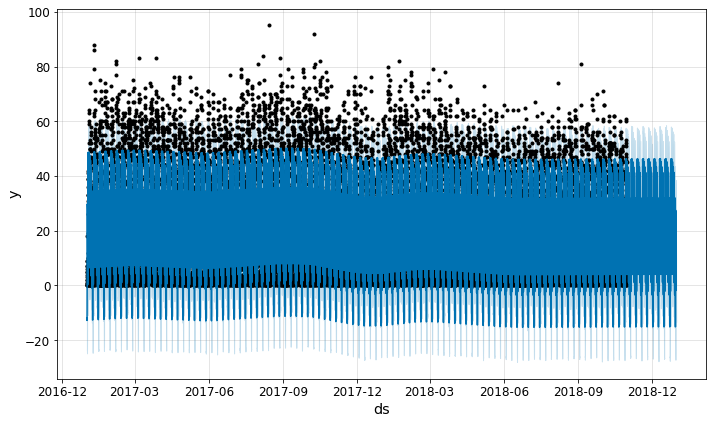

In [28]:
m_hourly.plot(forecast)
plt.show()

It's a little hard to read this still, but we can see that our forecast is definitely a little noisy. We can get a lot more insight into this data by looking at the components of the time series forecast.

Time series are often thought of as composed of two distinct parts. First, there is an overall trend in the data which says whether or not the level of the forecasted variable is trending up or down over time. Second, there is often a cyclical trend, commonly called seasonality. In our data, we have three cyclical trends that Prophet has identified. There is a cyclical trend from U.S. holidays (i.e. calls fall by a similar amount on every New Years Day), there is a weekly cyclical trend (i.e. Sundays seem to have very low calls), and there is a daily cyclical trend (people call during the day, not in the middle of the night). We can see these trends below.

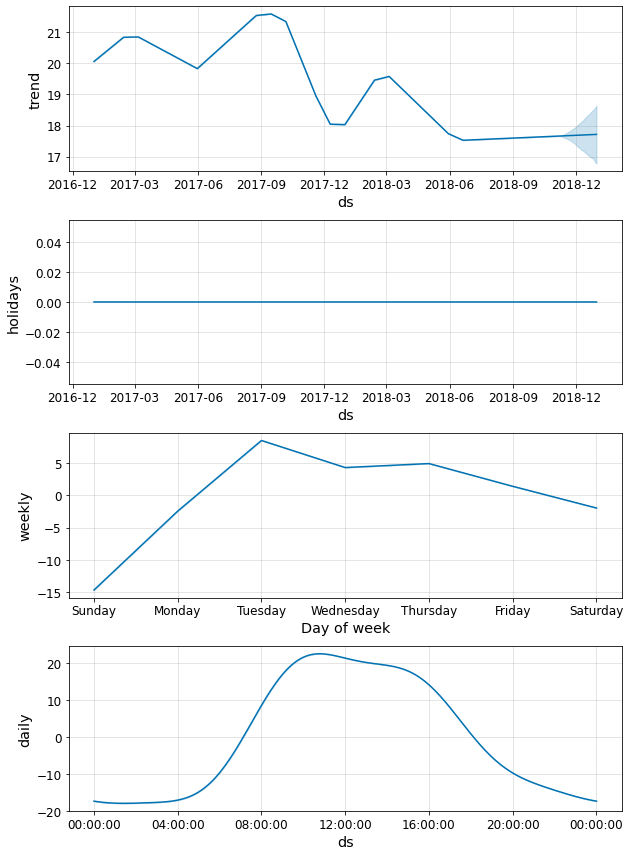

In [29]:
m_hourly.plot_components(forecast)
plt.show()

A way to understand the forecast is as a summation of the two components of the prediction, the trend and the seasonal factors. Therefore, on June 1st, 2018, a non-holiday Friday, at 12 pm the prediction would consist of the level on June 1st plus the additional component due to it being a Friday, and plus the additional component due to it being 12 pm.

Also, notice on the "trend" component above that starting on November 1st, 2018, there is a cone around the prediction. This is a 95% confidence interval. Notice how it is growing over time? This is an indication that forecasts really only work in the near term. It doesn't take long before the forecast is no longer valid.

Let's test the accuracy of our forecast on our testing set.

In [30]:
def accuracy(y_true, y_pred):
    """Function that returns a table showing RMSE and MAE."""
    acc_df = pd.DataFrame(data = {"RMSE": [mean_squared_error(y_true, y_pred)**(1/2)],
                                  "MAE": [mean_absolute_error(y_true, y_pred)],
                                  "R^2": [r2_score(y_true, y_pred)]})
    display(acc_df.style.hide_index())

In [31]:
accuracy(ts_hourly_test['y'], forecast.loc[forecast['ds'] >= training_cutoff]['yhat'])

It is hard to interpret this in isolation. However, we could seek to fine tune this model to improve the forecast.

## Identifying Areas of Growth

Above, there seems to be a broadly negative trend in the number of calls. However, the call data we looked at is aggregated across all areas and both brands (remember that Walker has both the "Los Defensores" brand and the "1-800-The-Law-2"). Can you, using similar analysis to the above, identify growing areas of the country or sub-brands?

To do this, you will want to filter the original calls data set like below.

In [32]:
df_calls_TL2 = df_calls.loc[df_calls['CompanyShortName'] == 'TL2'].copy()
df_calls_LD = df_calls.loc[df_calls['CompanyShortName'] != 'TL2'].copy()

# The Law 2

In [33]:
df_calls_TL2['StartTime'] = pd.to_datetime(df_calls_TL2['StartTime'])
# training_cutoff = pd.to_datetime('2018-11-1 00:00:00')
df_calls_TL2['StartTimeHourly'] = df_calls_TL2['StartTime'].apply(lambda dt: dt.replace(minute=0))
df_calls_TL2.groupby(['StartTimeHourly'])['CallId'].count()
df_calls_grouped_hourly = df_calls_TL2.groupby(['StartTimeHourly'])['CallId'].count()
# dates = pd.date_range(start=pd.to_datetime('2017-01-01 00:00:00'), end=pd.to_datetime('2018-12-30 23:00:00'), freq='H')
ts_hourly = pd.DataFrame({'ds': dates, 'y': np.zeros(len(dates))})
ts_hourly = ts_hourly.set_index('ds')
ts_hourly['y'].loc[df_calls_grouped_hourly.index] = df_calls_grouped_hourly
ts_hourly = ts_hourly.reset_index()
ts_hourly_train = ts_hourly.loc[ts_hourly['ds'] < training_cutoff].copy()
ts_hourly_test = ts_hourly.loc[ts_hourly['ds'] >= training_cutoff].copy()
# len(ts_hourly_train)
# len(ts_hourly_test)
tl2_hourly = Prophet()
tl2_hourly.add_country_holidays(country_name='US')
tl2_hourly.fit(ts_hourly_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


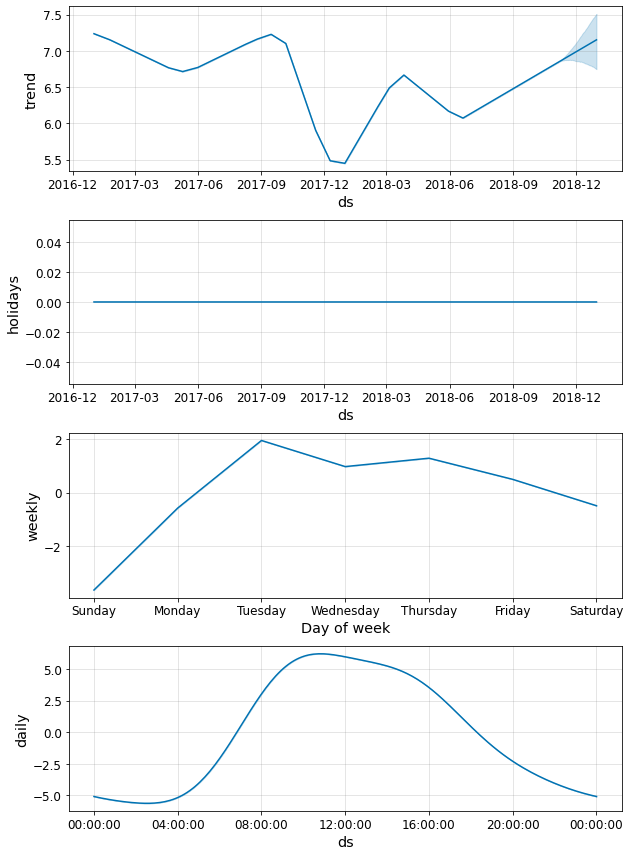

In [34]:
future = tl2_hourly.make_future_dataframe(periods=24*60, freq='H')
forecast = tl2_hourly.predict(future)
x=tl2_hourly.plot_components(forecast)


plt.show()
accuracy(ts_hourly_test['y'], forecast.loc[forecast['ds'] >= training_cutoff]['yhat'])

In [35]:
x.savefig("The_LAW.png")

# Los

In [36]:
df_calls_LD['StartTime'] = pd.to_datetime(df_calls_LD['StartTime'])
# training_cutoff = pd.to_datetime('2018-11-1 00:00:00')
df_calls_LD['StartTimeHourly'] = df_calls_LD['StartTime'].apply(lambda dt: dt.replace(minute=0))
df_calls_LD.groupby(['StartTimeHourly'])['CallId'].count()
df_calls_grouped_hourly = df_calls_LD.groupby(['StartTimeHourly'])['CallId'].count()
# dates = pd.date_range(start=pd.to_datetime('2017-01-01 00:00:00'), end=pd.to_datetime('2018-12-30 23:00:00'), freq='H')
ts_hourly = pd.DataFrame({'ds': dates, 'y': np.zeros(len(dates))})
ts_hourly = ts_hourly.set_index('ds')
ts_hourly['y'].loc[df_calls_grouped_hourly.index] = df_calls_grouped_hourly
ts_hourly = ts_hourly.reset_index()
ts_hourly_train = ts_hourly.loc[ts_hourly['ds'] < training_cutoff].copy()
ts_hourly_test = ts_hourly.loc[ts_hourly['ds'] >= training_cutoff].copy()
# len(ts_hourly_train)
# len(ts_hourly_test)
ld_hourly = Prophet()
ld_hourly.add_country_holidays(country_name='US')
ld_hourly.fit(ts_hourly_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


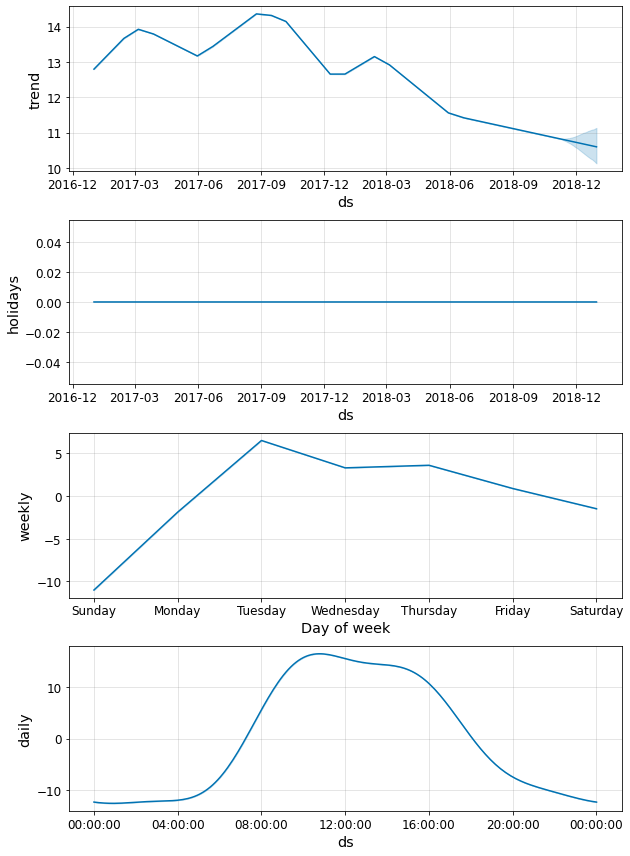

In [37]:
future = ld_hourly.make_future_dataframe(periods=24*60, freq='H')
forecast = ld_hourly.predict(future)
z=ld_hourly.plot_components(forecast)
plt.show()
accuracy(ts_hourly_test['y'], forecast.loc[forecast['ds'] >= training_cutoff]['yhat'])

In [38]:
z.savefig("Los Defensores.png")

In [39]:
# df_calls.columns
# uniqueValues = (df_calls['MediaGroup']).unique()
# uniqueValues

In [40]:
# uniqueValues = uniqueValues[0:2]
# uniqueValues

Traditional


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


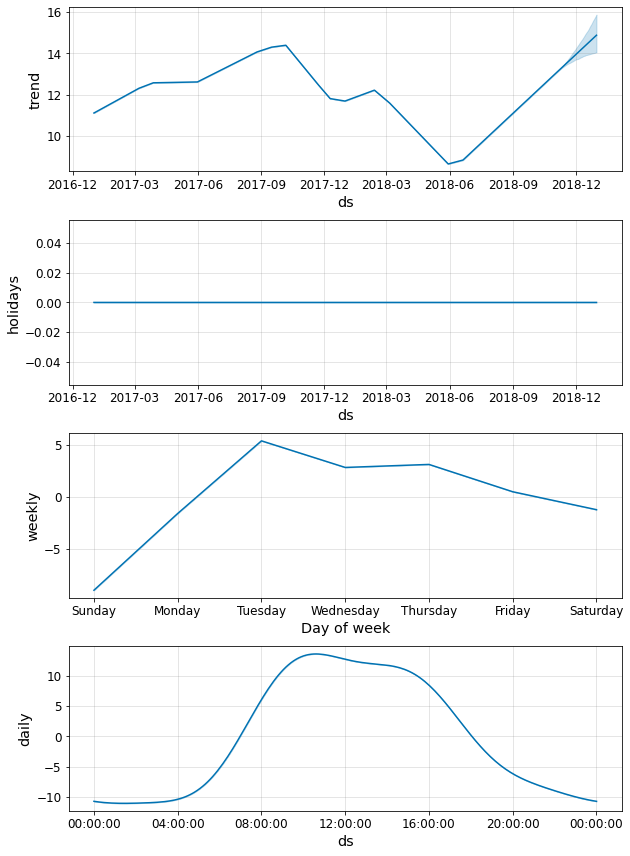

Digital


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


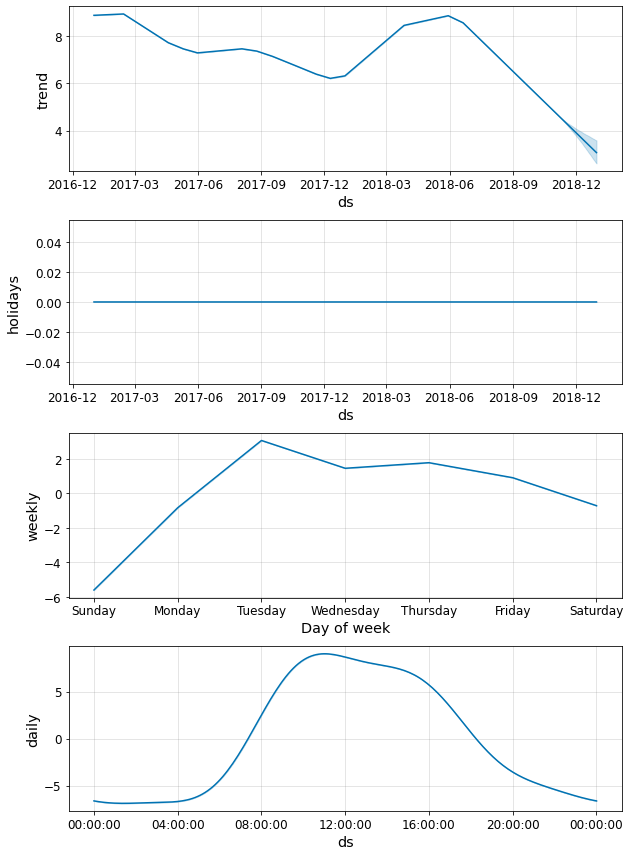

In [41]:
uniqueValues = (df_calls['MediaGroup']).unique()
uniqueValues = uniqueValues[0:2]

for media in uniqueValues:
    if (media != 'nan'):
        print (media)
        copy = df_calls.loc[df_calls['MediaGroup'] == media].copy()
        copy['StartTime'] = pd.to_datetime(copy['StartTime'])
        # training_cutoff = pd.to_datetime('2018-11-1 00:00:00')
        copy['StartTimeHourly'] = copy['StartTime'].apply(lambda dt: dt.replace(minute=0))
        copy.groupby(['StartTimeHourly'])['CallId'].count()
        df_calls_grouped_hourly = copy.groupby(['StartTimeHourly'])['CallId'].count()

        ts_hourly = pd.DataFrame({'ds': dates, 'y': np.zeros(len(dates))})
        ts_hourly = ts_hourly.set_index('ds')
        ts_hourly['y'].loc[df_calls_grouped_hourly.index] = df_calls_grouped_hourly
        ts_hourly = ts_hourly.reset_index()
        ts_hourly_train = ts_hourly.loc[ts_hourly['ds'] < training_cutoff].copy()
        ts_hourly_test = ts_hourly.loc[ts_hourly['ds'] >= training_cutoff].copy()
        # len(ts_hourly_train)
        # len(ts_hourly_test)
        x = Prophet()
        x.add_country_holidays(country_name='US')
        x.fit(ts_hourly_train)

        future = x.make_future_dataframe(periods=24*60, freq='H')
        forecast = x.predict(future)
        z=x.plot_components(forecast)
        plt.show()
        z.savefig(media + ".png")
        accuracy(ts_hourly_test['y'], forecast.loc[forecast['ds'] >= training_cutoff]['yhat'])


Analyzing THE LAW minifirm
Traditional


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


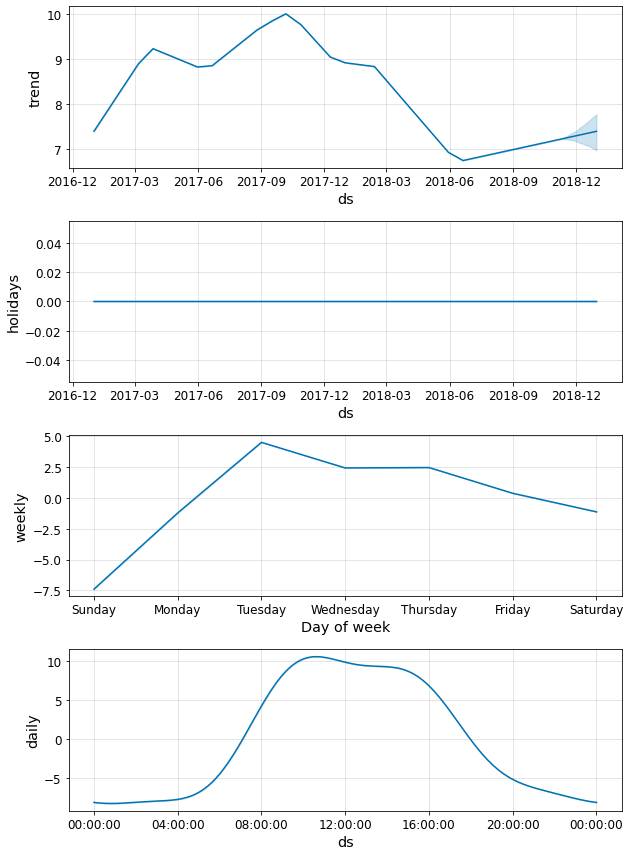

Analyzing THE LAW minifirm
Digital


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


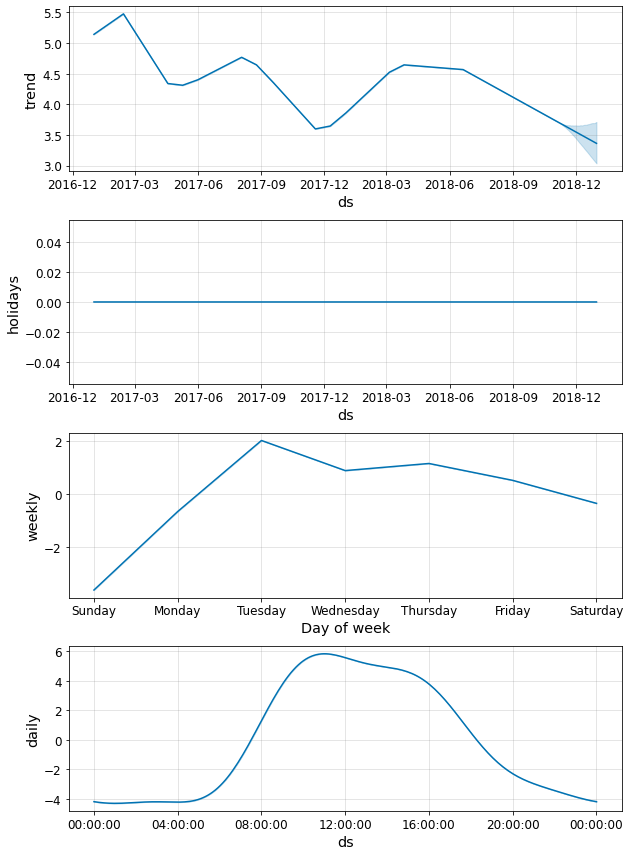

Analyzing Los Defensores minifirm
Traditional


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


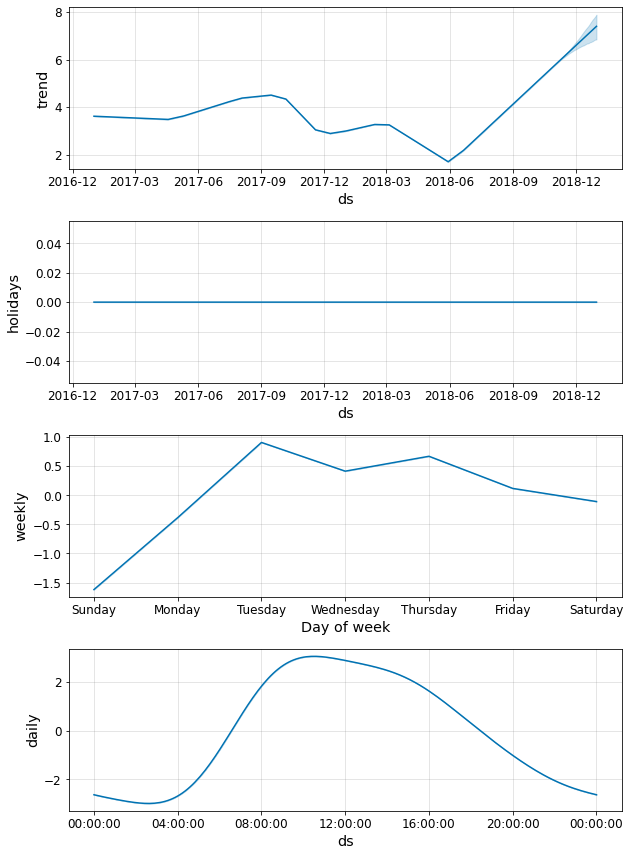

Analyzing Los Defensores minifirm
Digital


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


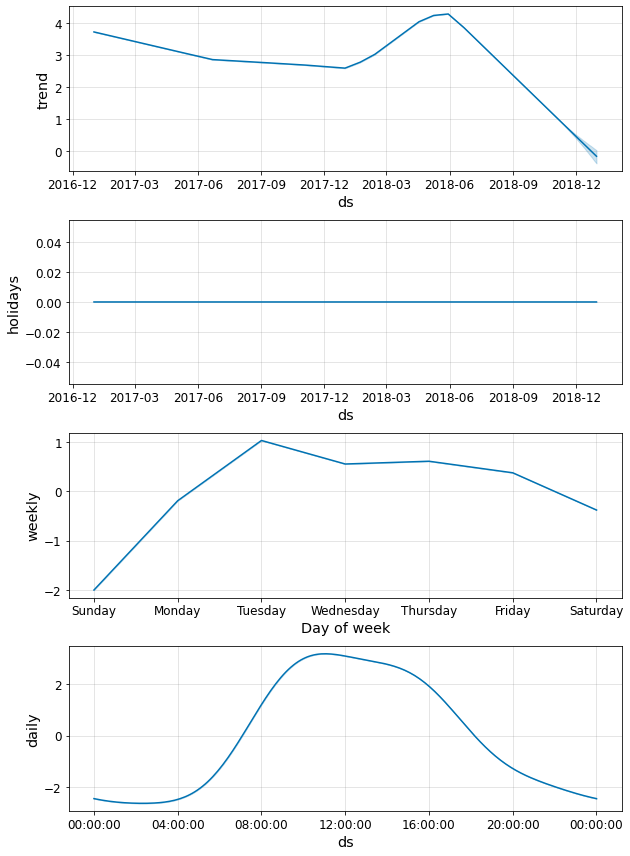

In [42]:
#Defined above
# df_calls_TL2 = df_calls.loc[df_calls['CompanyShortName'] == 'TL2'].copy()
# df_calls_LD = df_calls.loc[df_calls['CompanyShortName'] != 'TL2'].copy()

df_arr= [df_calls_LD, df_calls_TL2]
z=1

for df in df_arr:
    if z == 1:
        name = "THE LAW"
        z+=1
    else : 
        name = "Los Defensores"
    for media in uniqueValues:
        if (media != np.nan):
            print("Analyzing "+name+" minifirm")
            print (media)
            copy = df.loc[df['MediaGroup'] == media].copy()
            copy['StartTime'] = pd.to_datetime(copy['StartTime'])
            # training_cutoff = pd.to_datetime('2018-11-1 00:00:00')
            copy['StartTimeHourly'] = copy['StartTime'].apply(lambda dt: dt.replace(minute=0))
            copy.groupby(['StartTimeHourly'])['CallId'].count()
            df_grouped_hourly = copy.groupby(['StartTimeHourly'])['CallId'].count()

            ts_hourly = pd.DataFrame({'ds': dates, 'y': np.zeros(len(dates))})
            ts_hourly = ts_hourly.set_index('ds')
            ts_hourly['y'].loc[df_grouped_hourly.index] = df_grouped_hourly
            ts_hourly = ts_hourly.reset_index()
            ts_hourly_train = ts_hourly.loc[ts_hourly['ds'] < training_cutoff].copy()
            ts_hourly_test = ts_hourly.loc[ts_hourly['ds'] >= training_cutoff].copy()
            # len(ts_hourly_train)
            # len(ts_hourly_test)
            x = Prophet()
            x.add_country_holidays(country_name='US')
            x.fit(ts_hourly_train)

            future = x.make_future_dataframe(periods=24*60, freq='H')
            forecast = x.predict(future)
            z=x.plot_components(forecast)
            plt.show()
            z.savefig(name + "_" + media + ".png")
            accuracy(ts_hourly_test['y'], forecast.loc[forecast['ds'] >= training_cutoff]['yhat'])

In [46]:
df_calls_TL2['State'].unique()

array(['VA', 'FL', 'GA', 'PA', 'OK', 'CA', 'OH', 'WV', 'AL', 'MN', 'WY',
       'WI', 'TX', 'WA', 'MO', 'NY', 'TN', 'NC', 'OR', 'MS', 'MD', 'AZ',
       'LA', 'NJ', 'IL', 'SC', 'MI', 'CO', 'CT', 'NM', 'NV', 'MA', 'IN',
       'UT', 'KY', 'IA', 'KS', 'DC', 'NE', 'AR', 'NH', 'DE', 'ME', 'HI',
       'MT', 'SD', 'VT', 'ND', 'ID', 'RI', 'AK', nan], dtype=object)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing TN
Analyzing THE LAW minifirm
Traditional


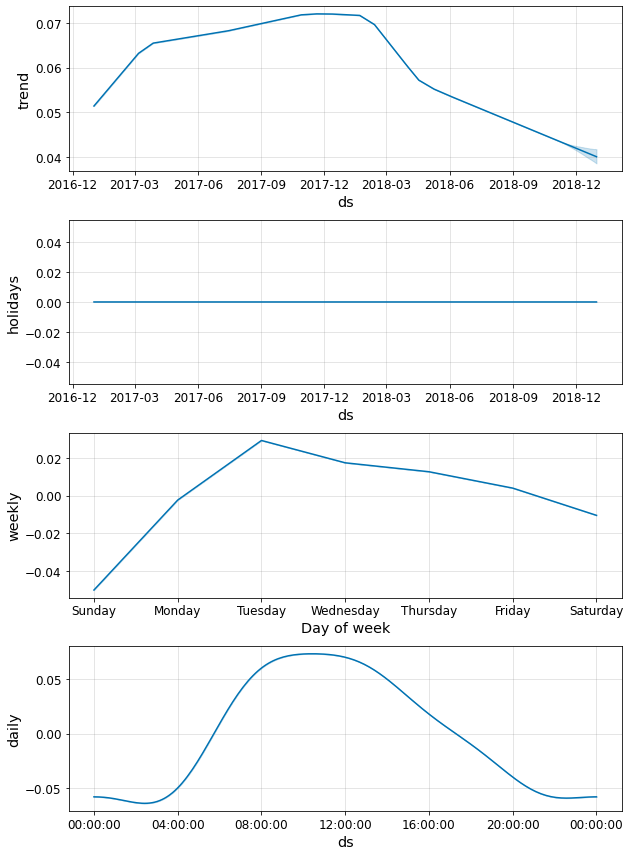

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


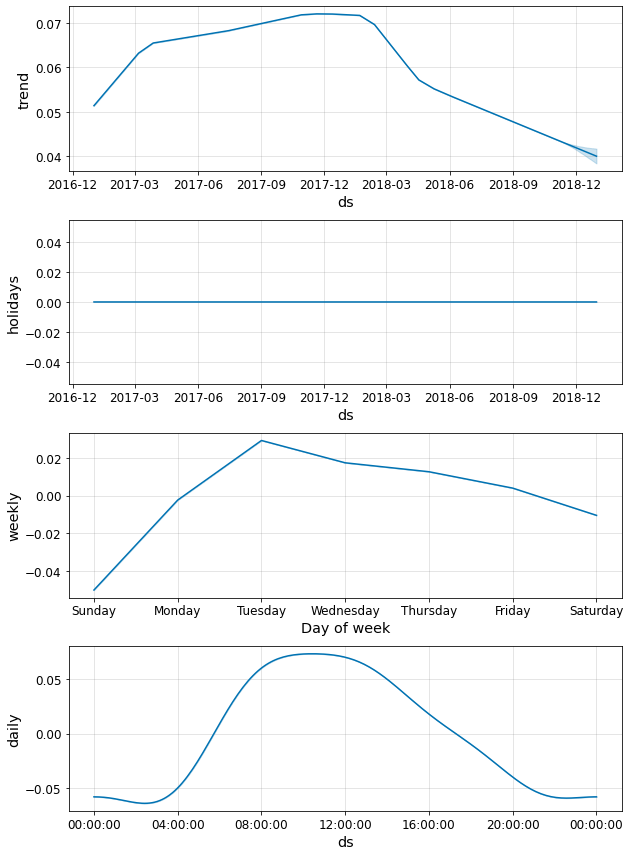

Analyzing TX
Analyzing THE LAW minifirm
Traditional


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


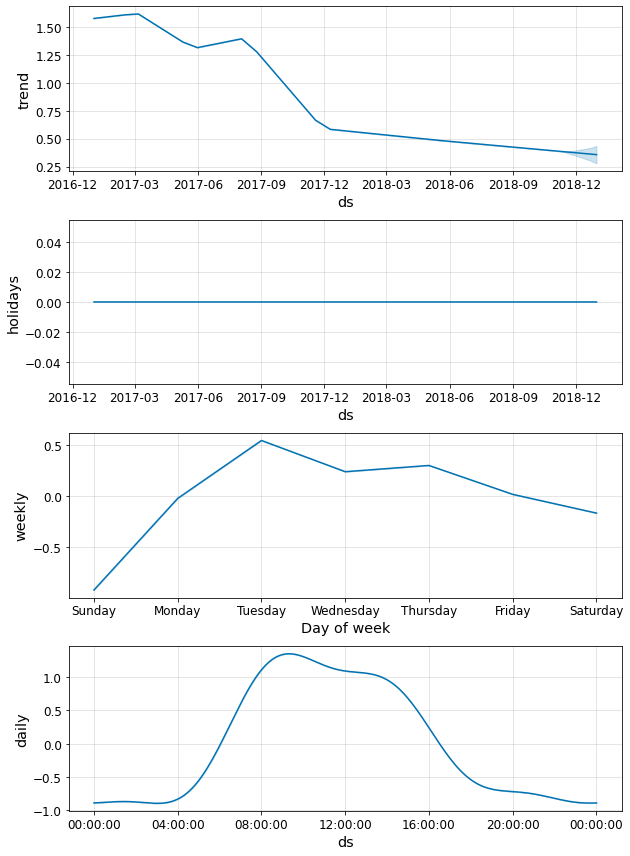

Analyzing THE LAW minifirm
Digital


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


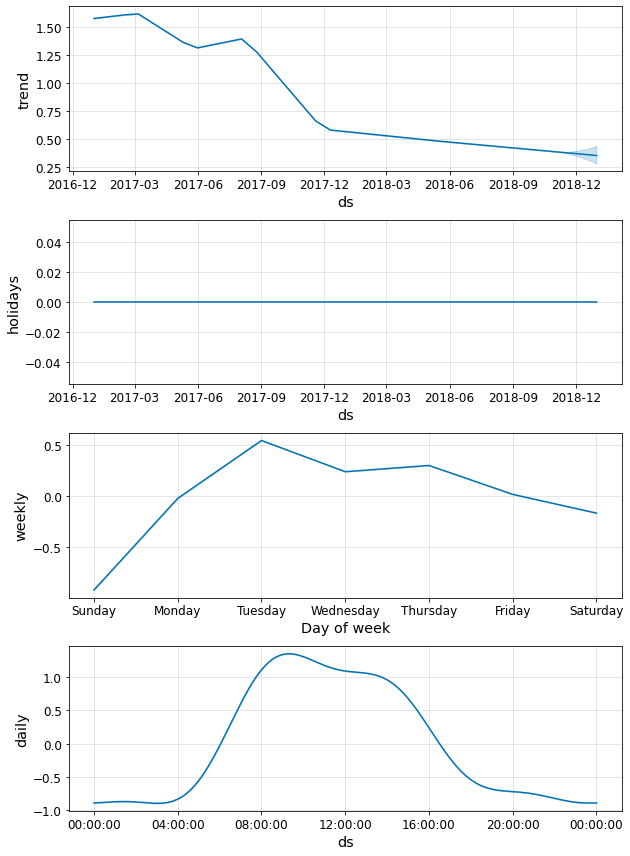

Analyzing CA
Analyzing THE LAW minifirm
Traditional


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


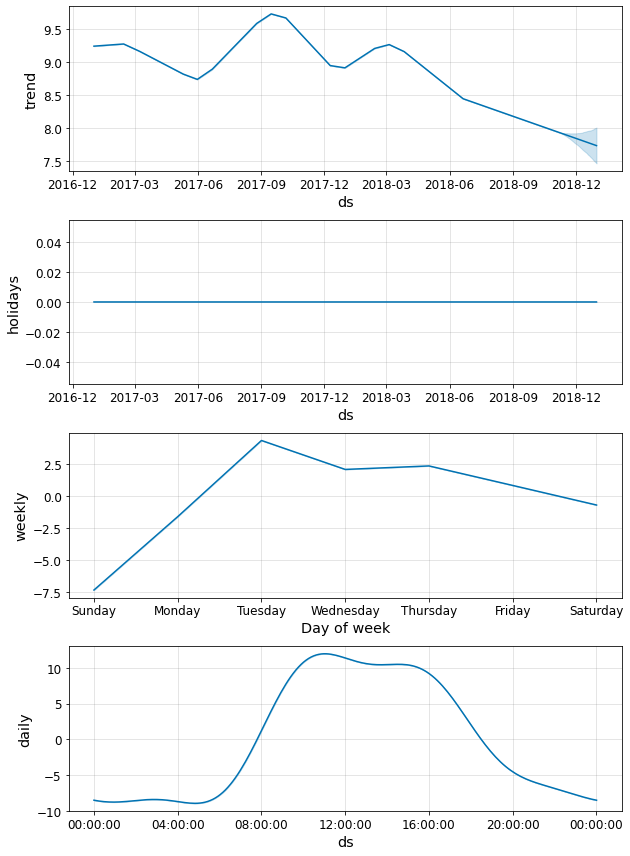

Analyzing THE LAW minifirm
Digital


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


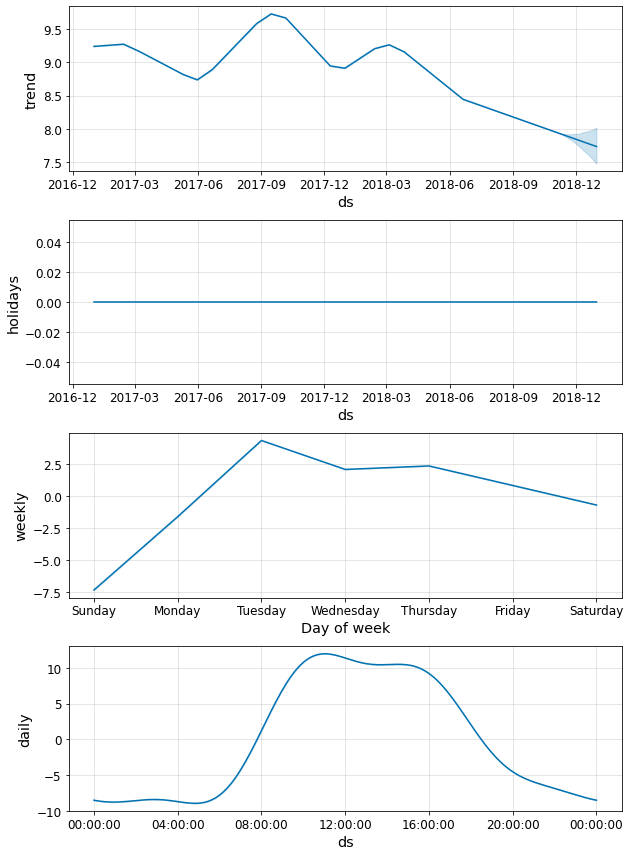

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing NY
Analyzing THE LAW minifirm
Traditional


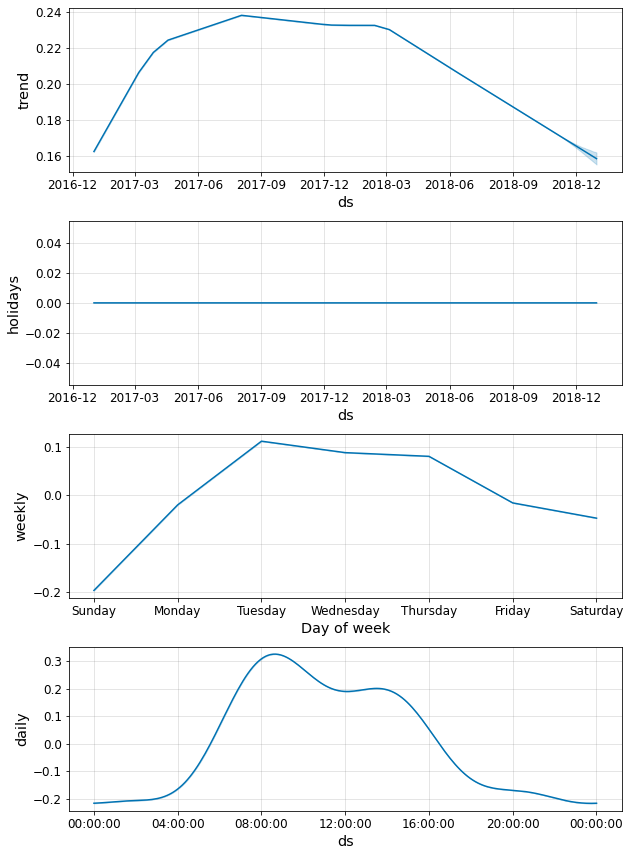

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


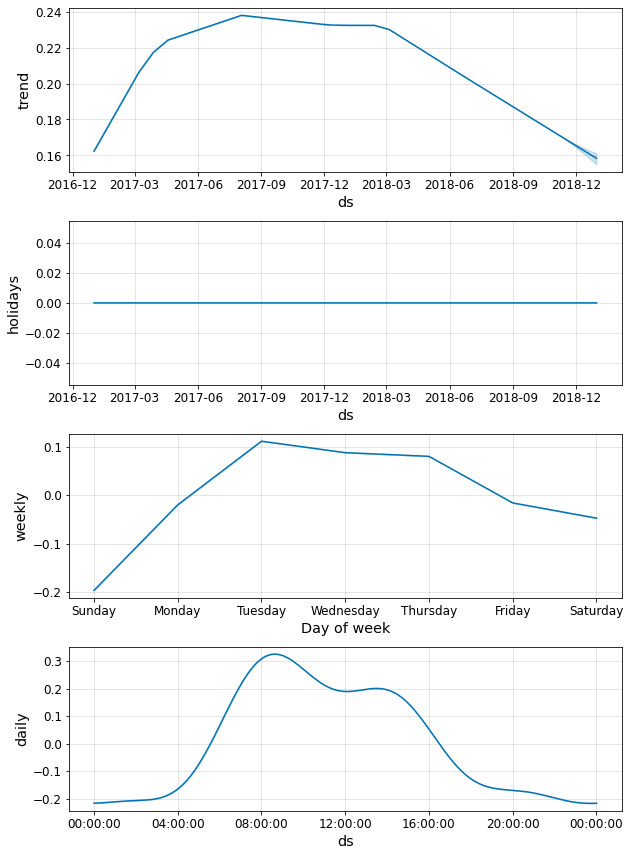

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing AZ
Analyzing THE LAW minifirm
Traditional


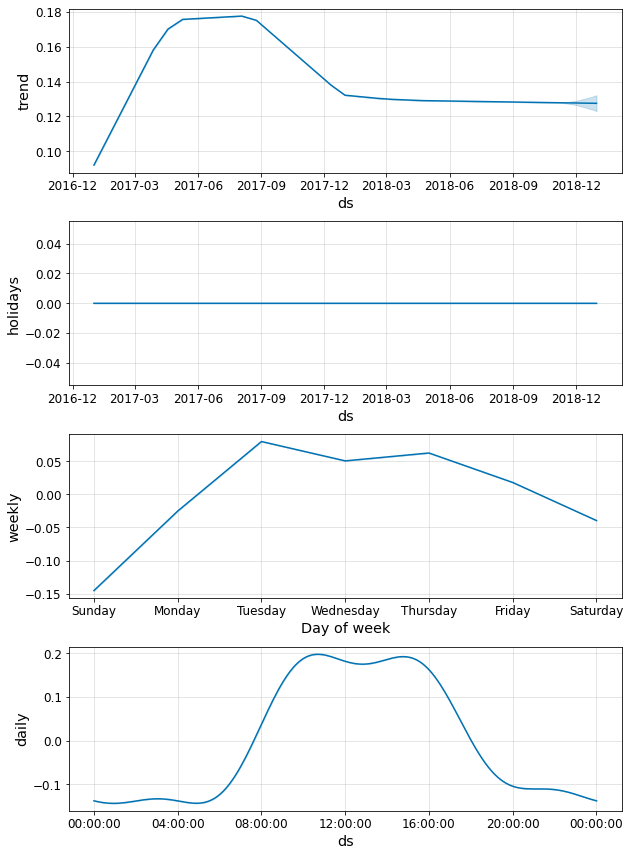

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


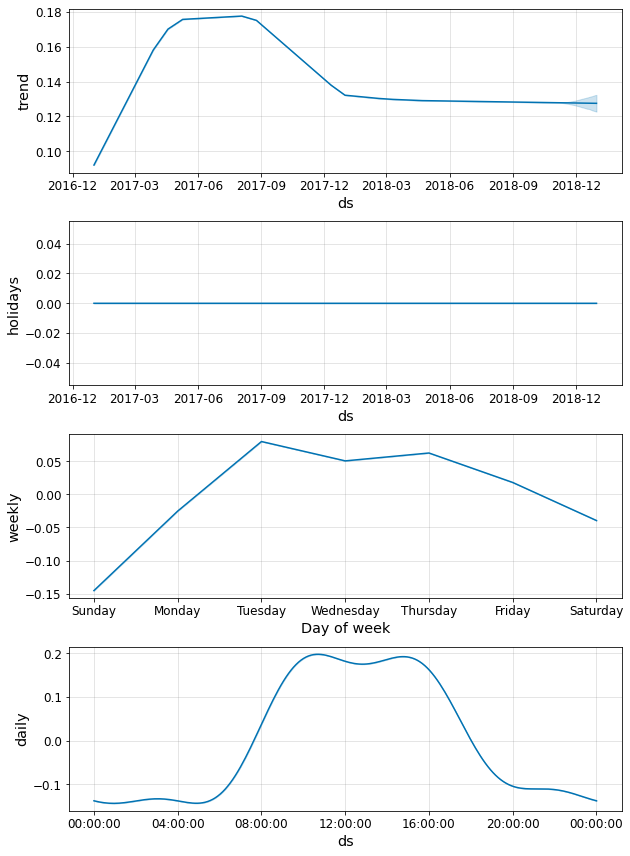

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing CO
Analyzing THE LAW minifirm
Traditional


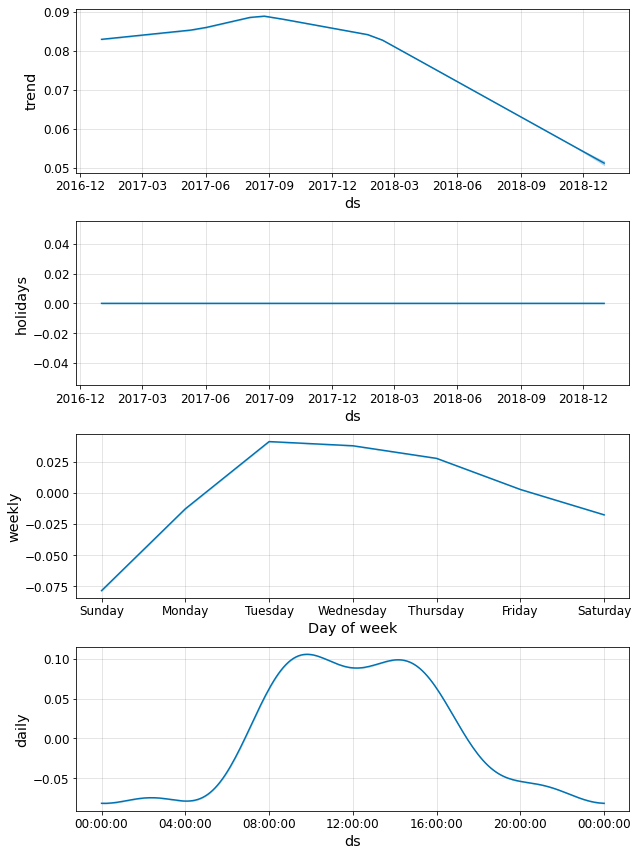

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


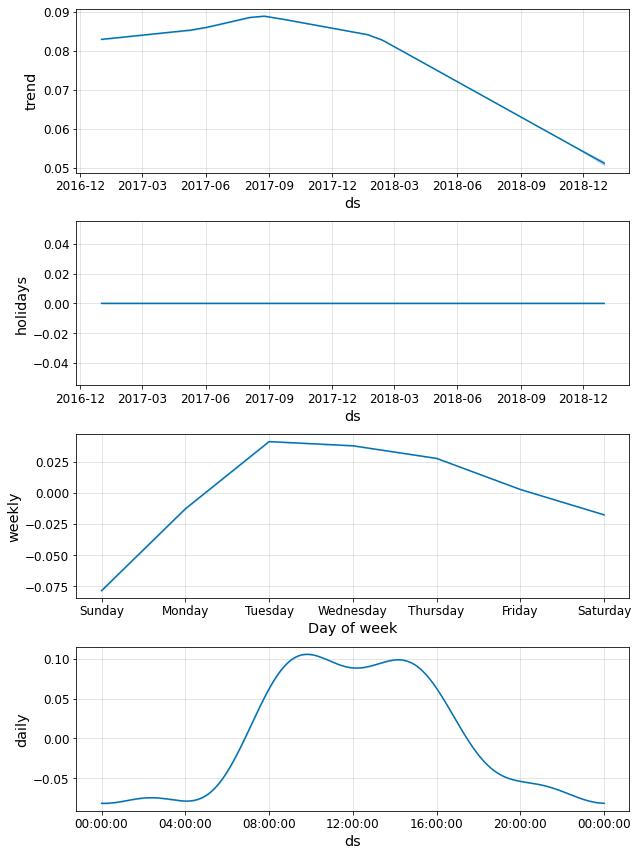

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing FL
Analyzing THE LAW minifirm
Traditional


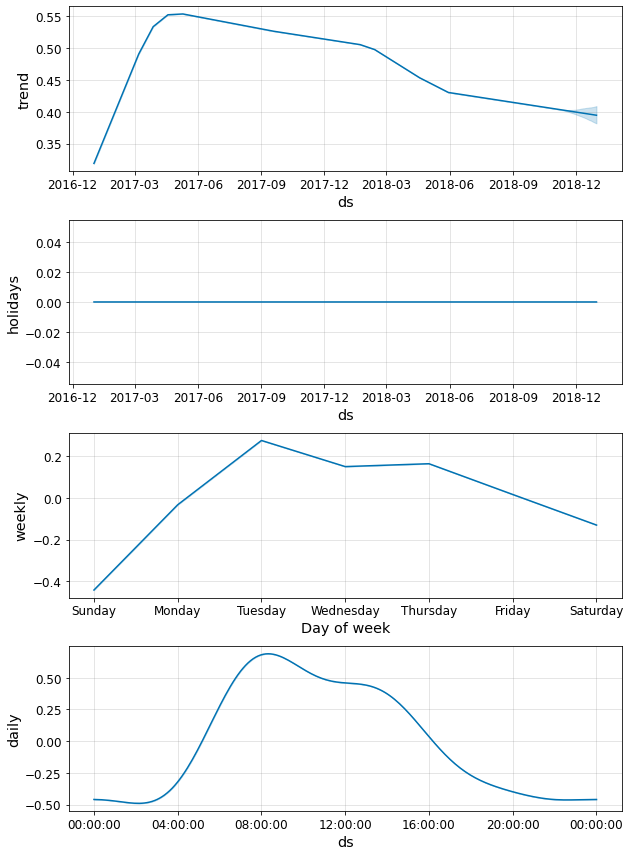

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


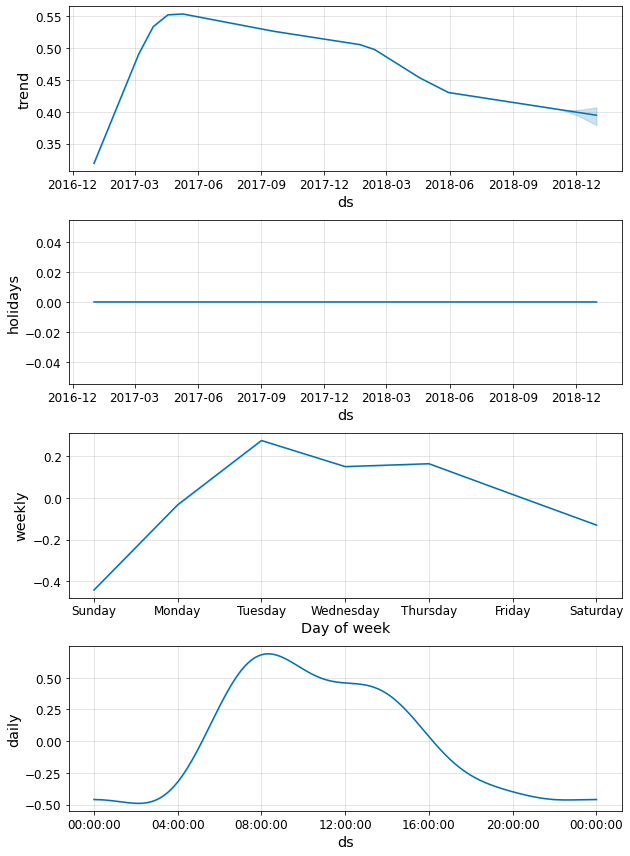

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing PA
Analyzing THE LAW minifirm
Traditional


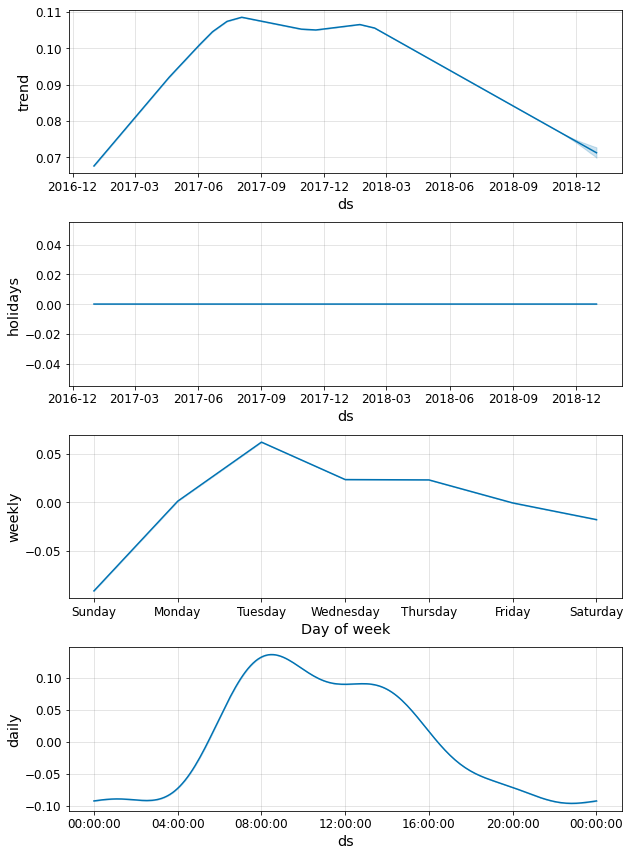

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


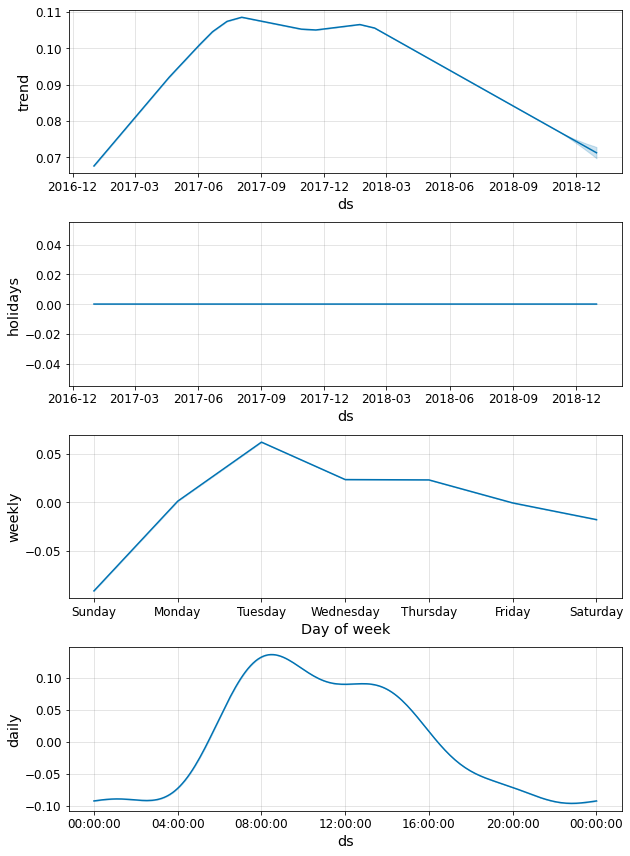

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing KS
Analyzing THE LAW minifirm
Traditional


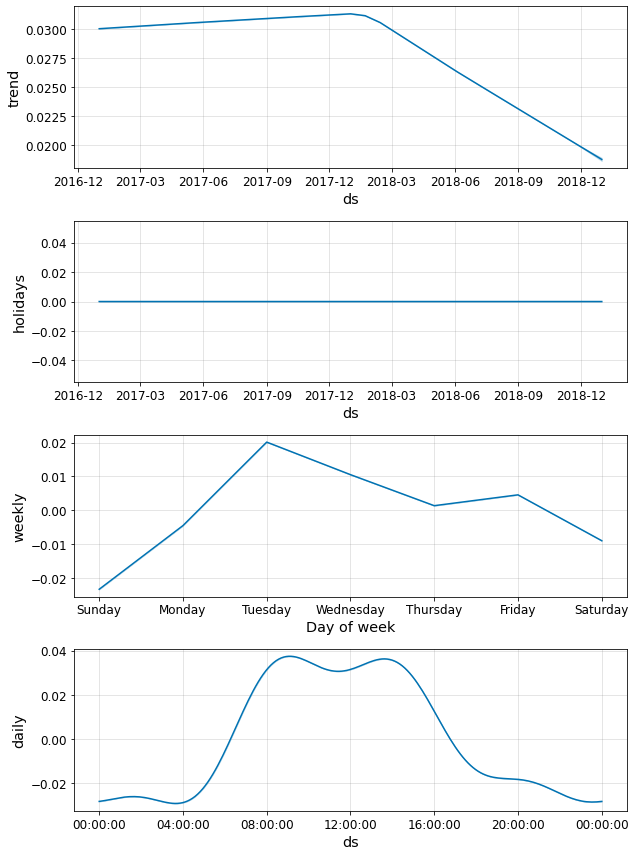

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


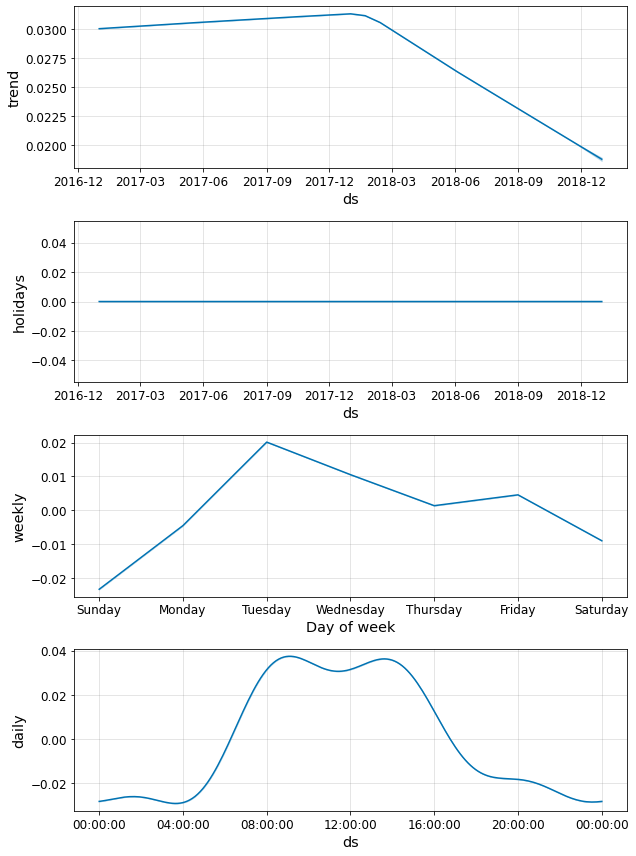

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing MD
Analyzing THE LAW minifirm
Traditional


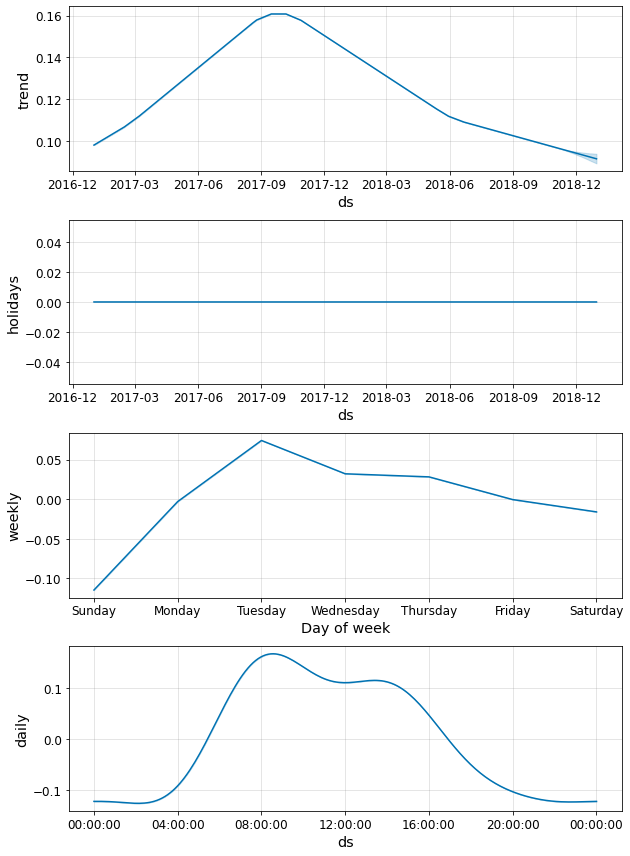

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


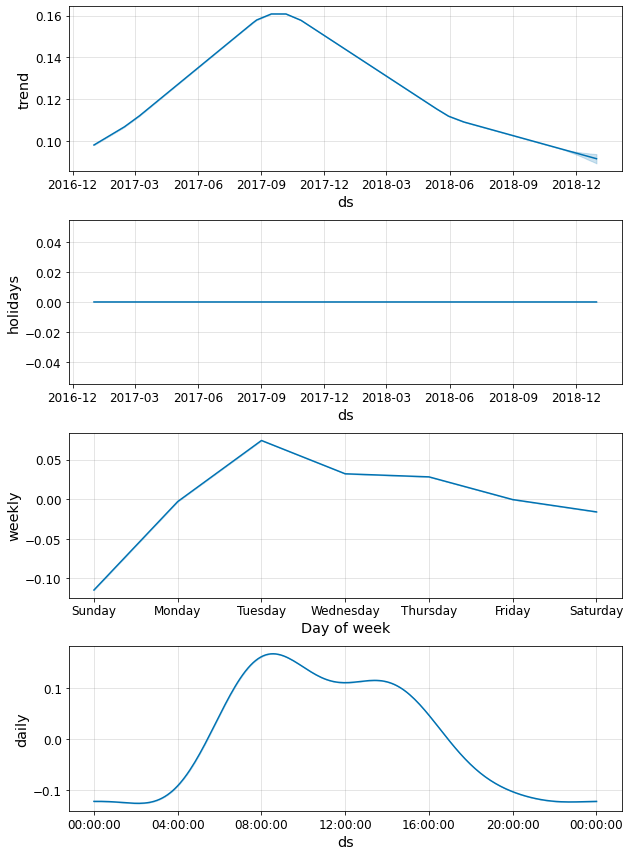

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing GA
Analyzing THE LAW minifirm
Traditional


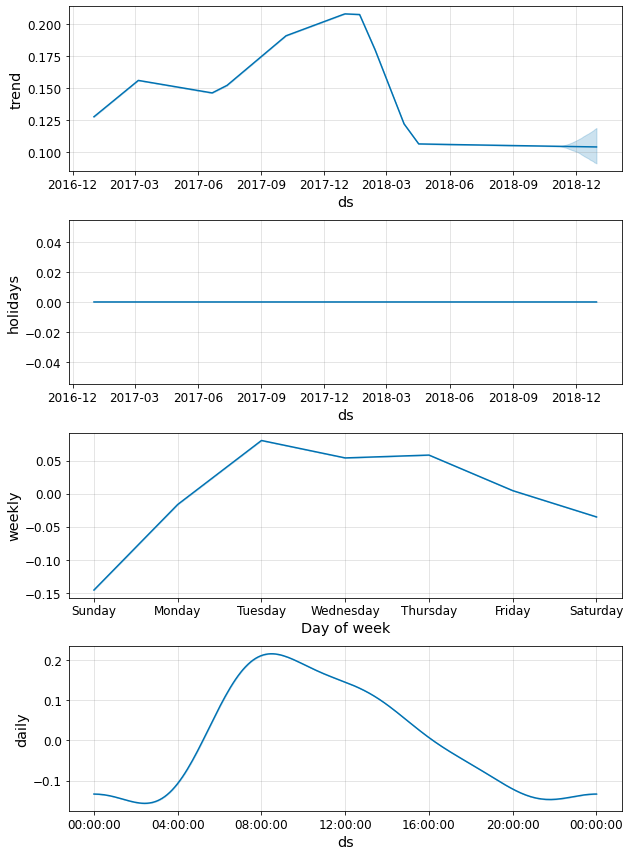

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


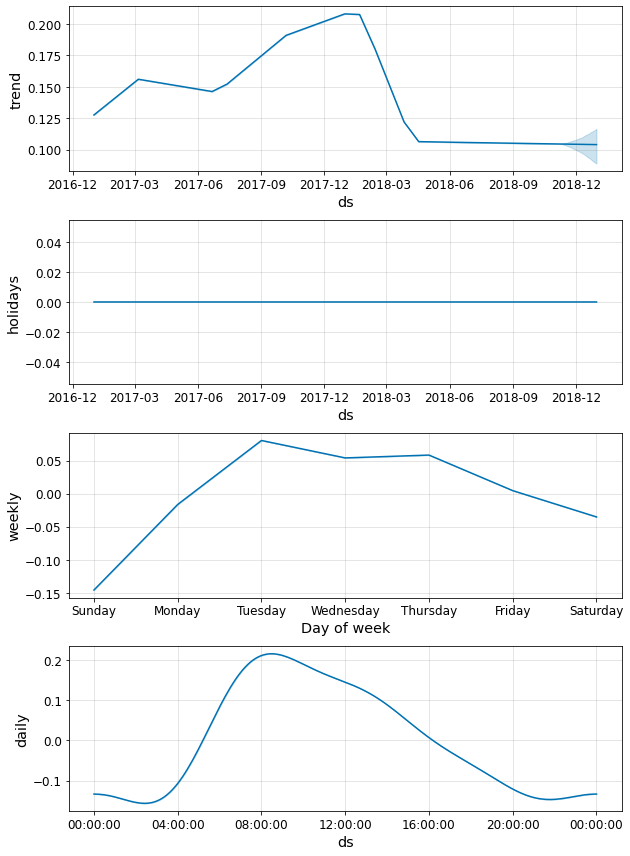

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing NC
Analyzing THE LAW minifirm
Traditional


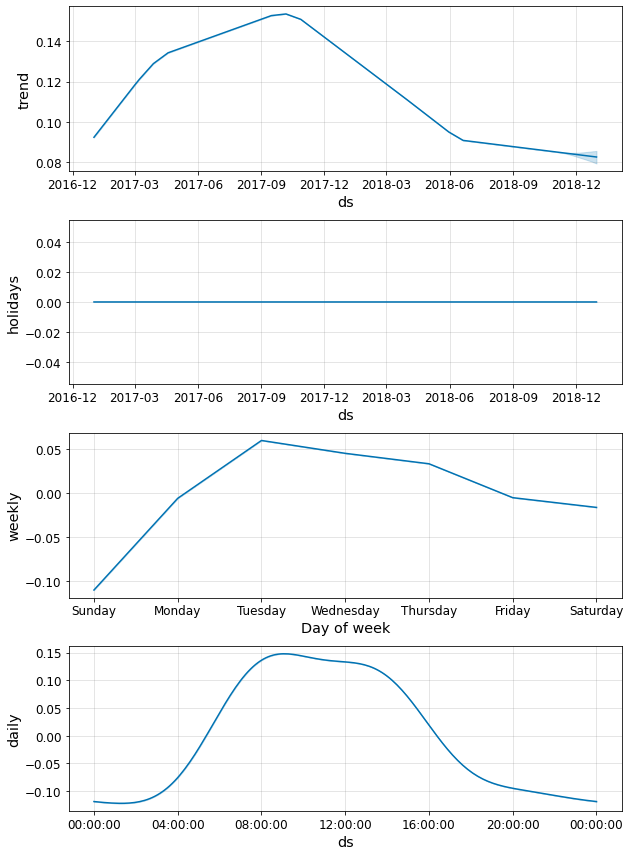

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


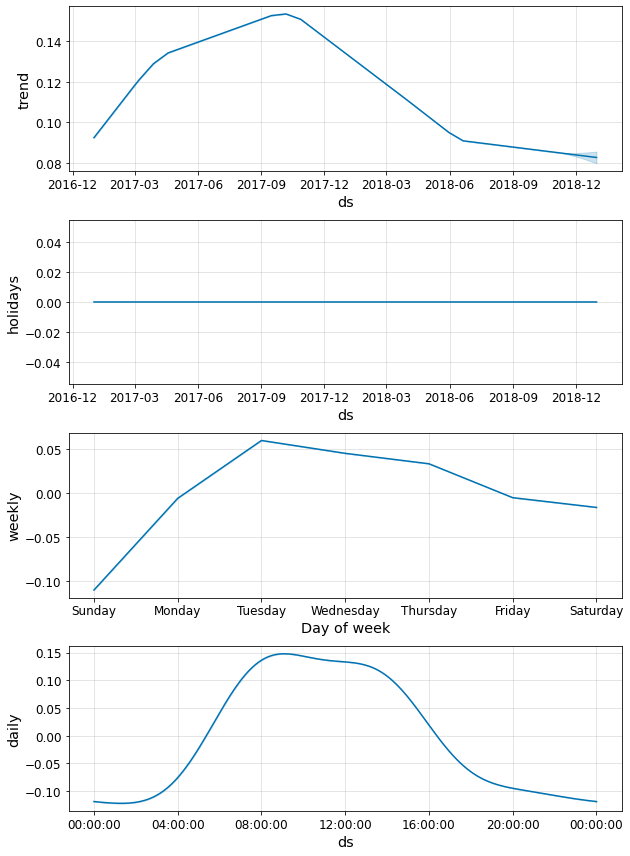

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing OK
Analyzing THE LAW minifirm
Traditional


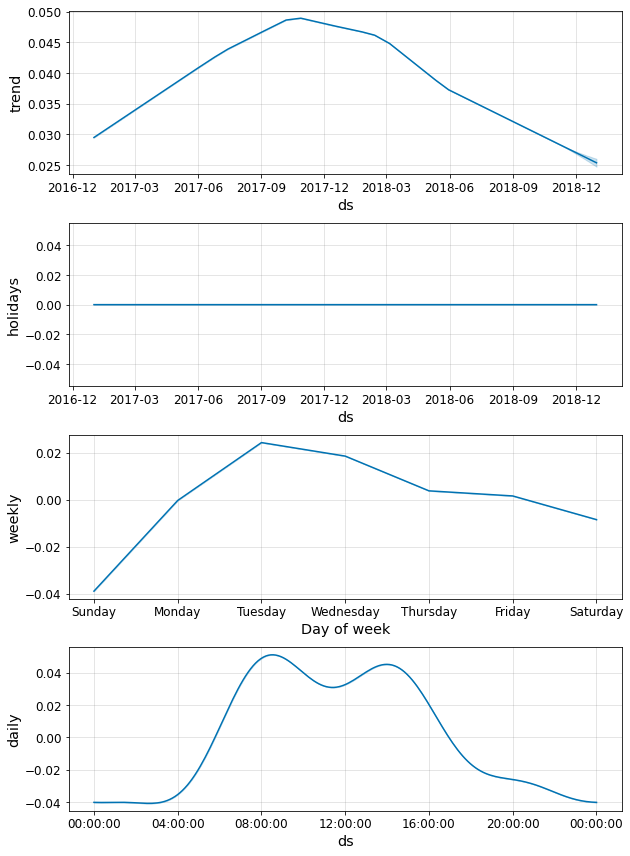

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


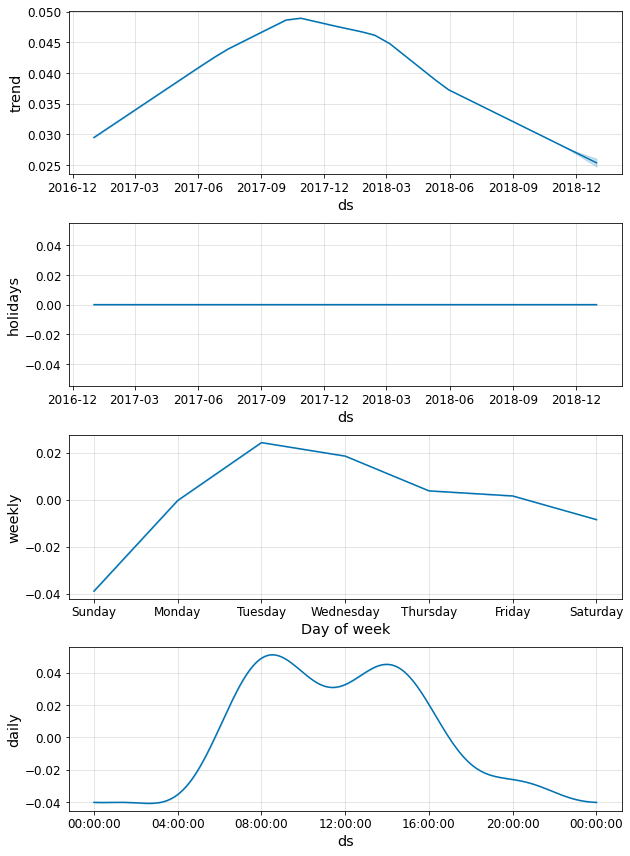

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing ID
Analyzing THE LAW minifirm
Traditional


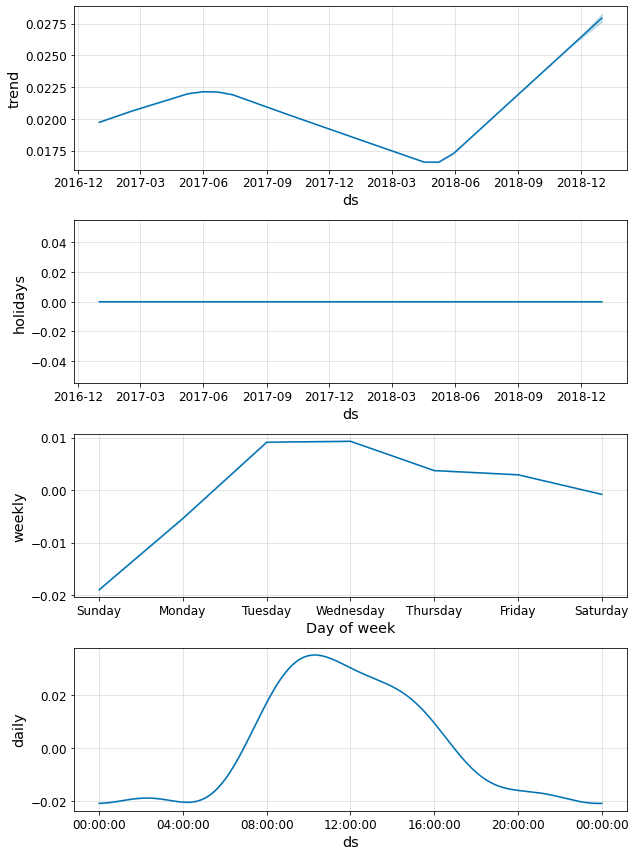

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


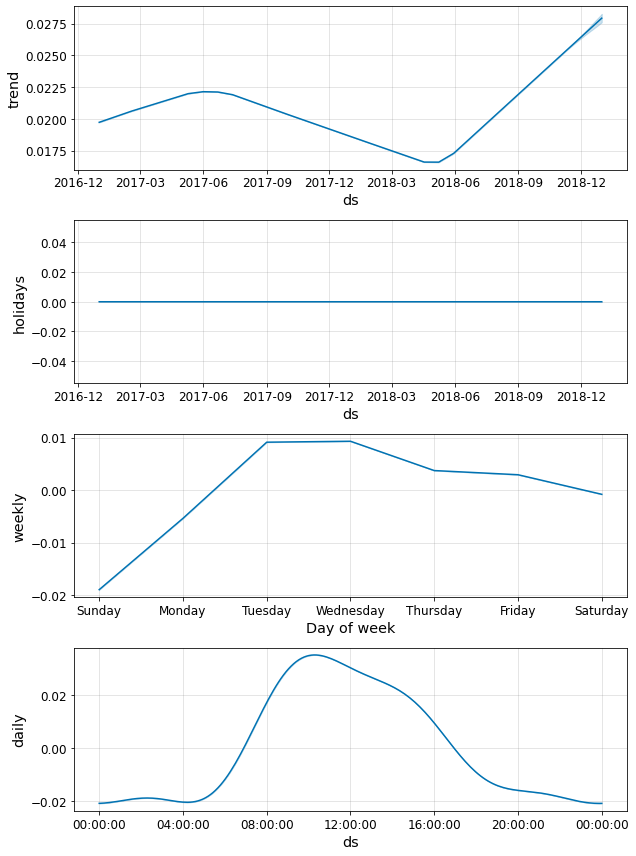

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing NJ
Analyzing THE LAW minifirm
Traditional


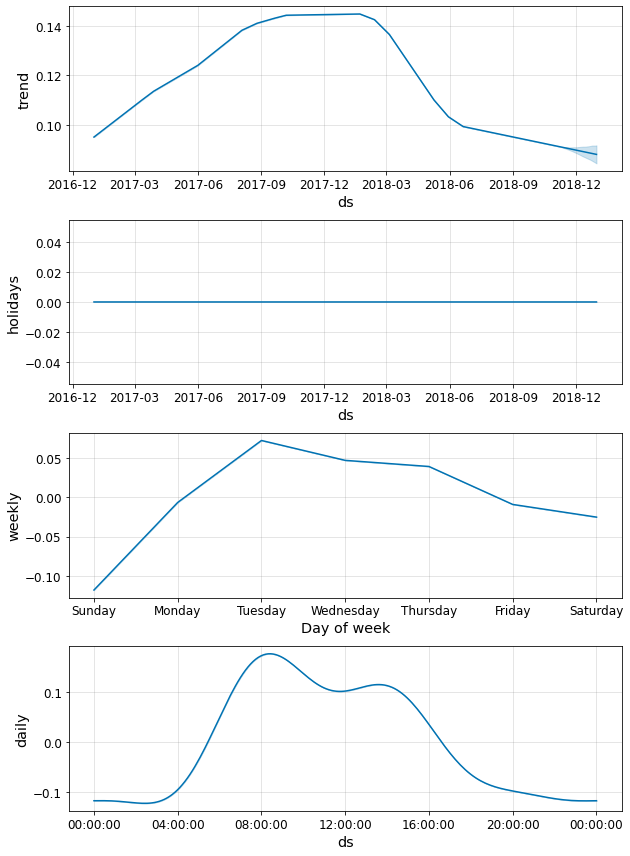

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


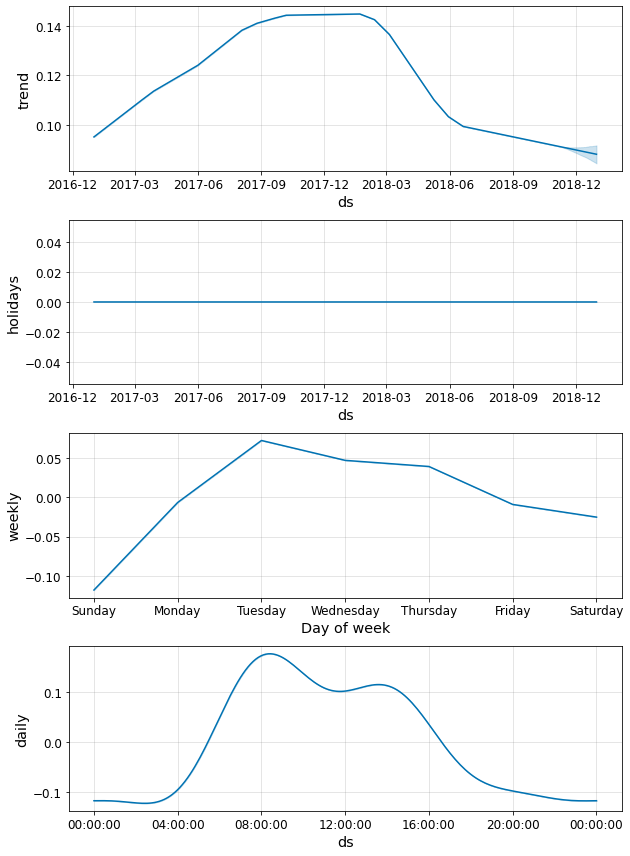

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing NM
Analyzing THE LAW minifirm
Traditional


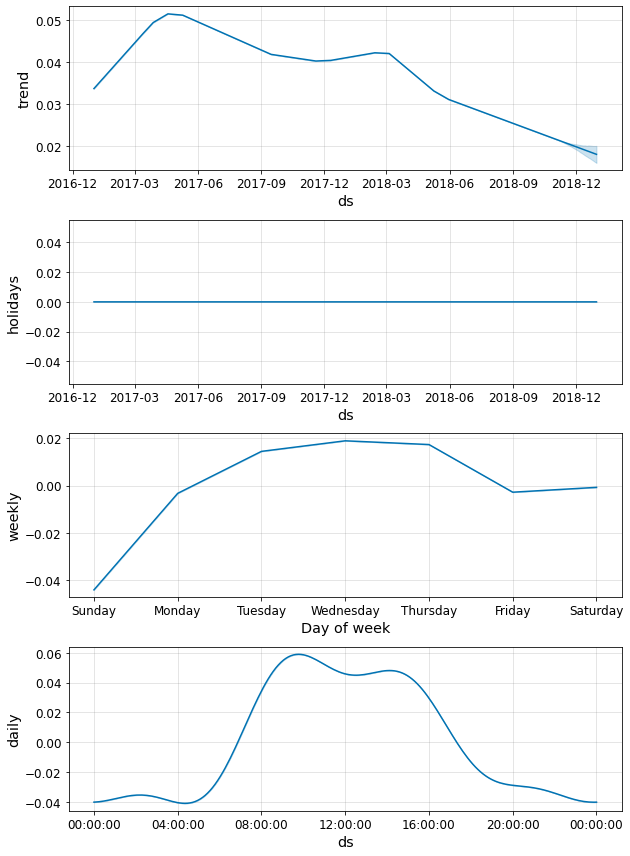

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


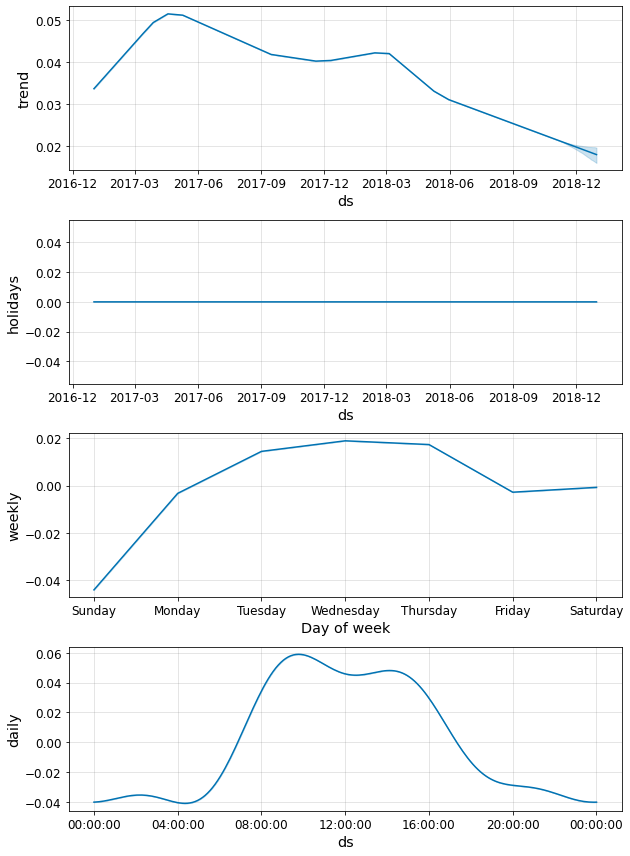

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing WA
Analyzing THE LAW minifirm
Traditional


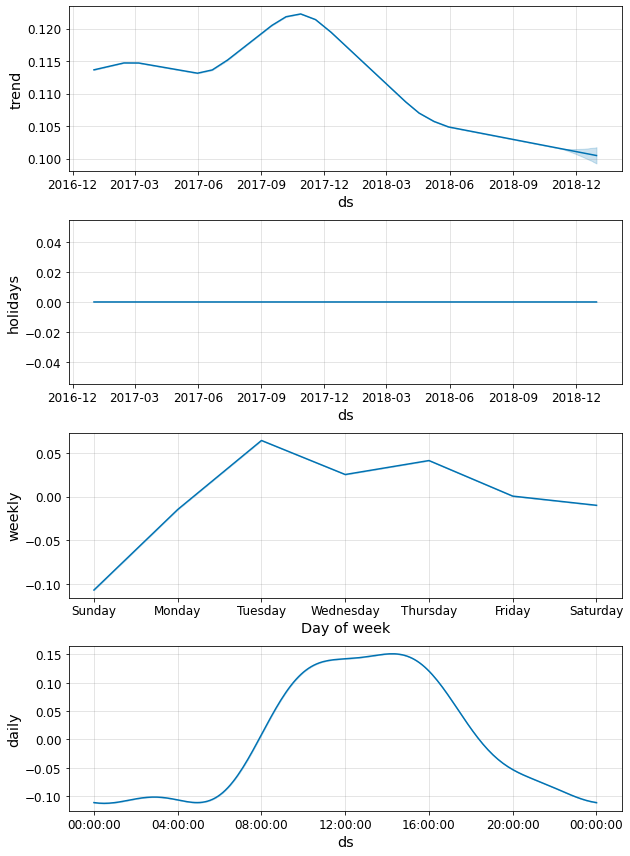

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


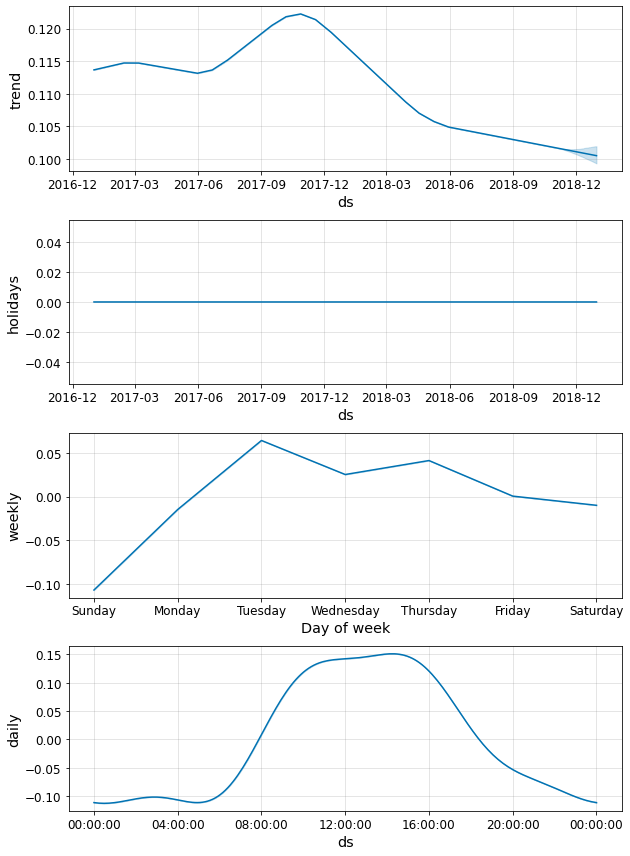

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing OR
Analyzing THE LAW minifirm
Traditional


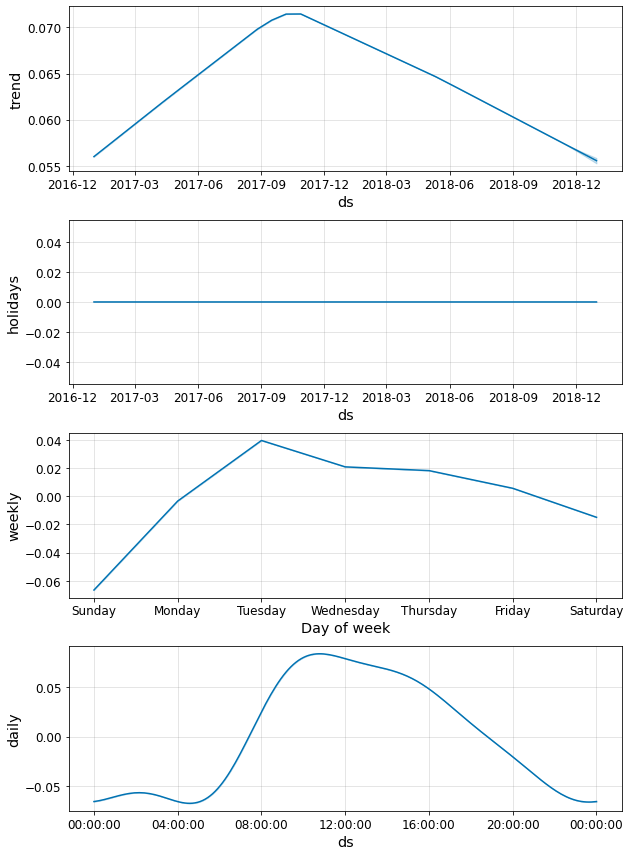

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


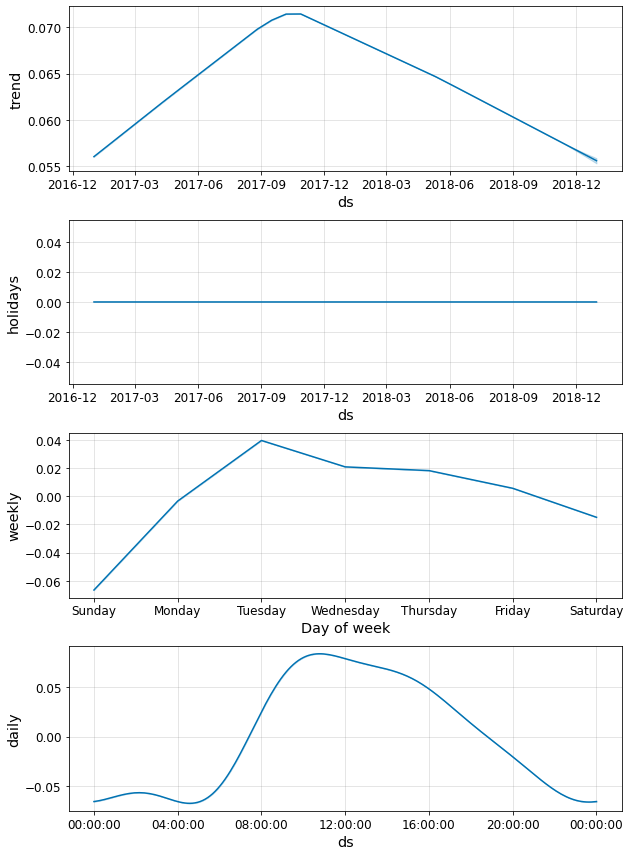

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing IN
Analyzing THE LAW minifirm
Traditional


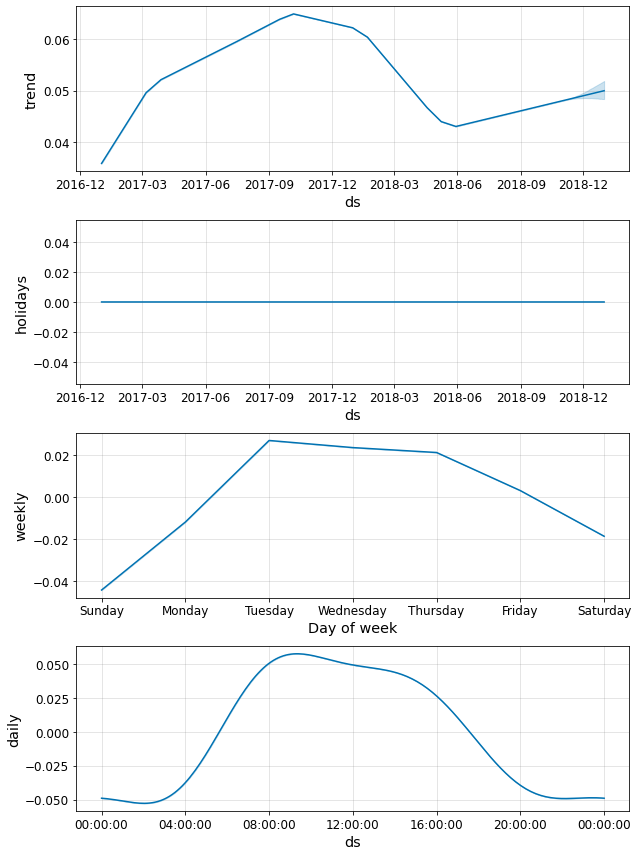

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


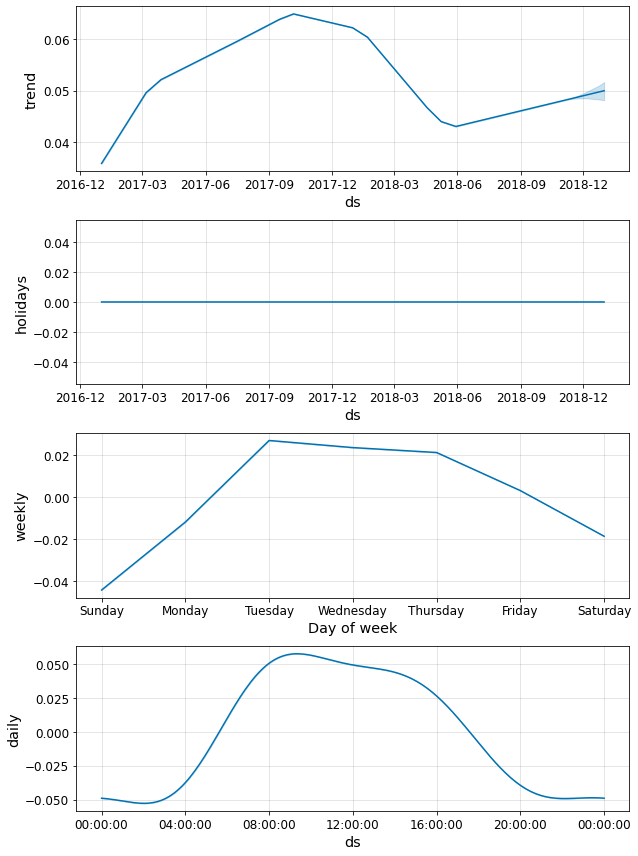

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing VA
Analyzing THE LAW minifirm
Traditional


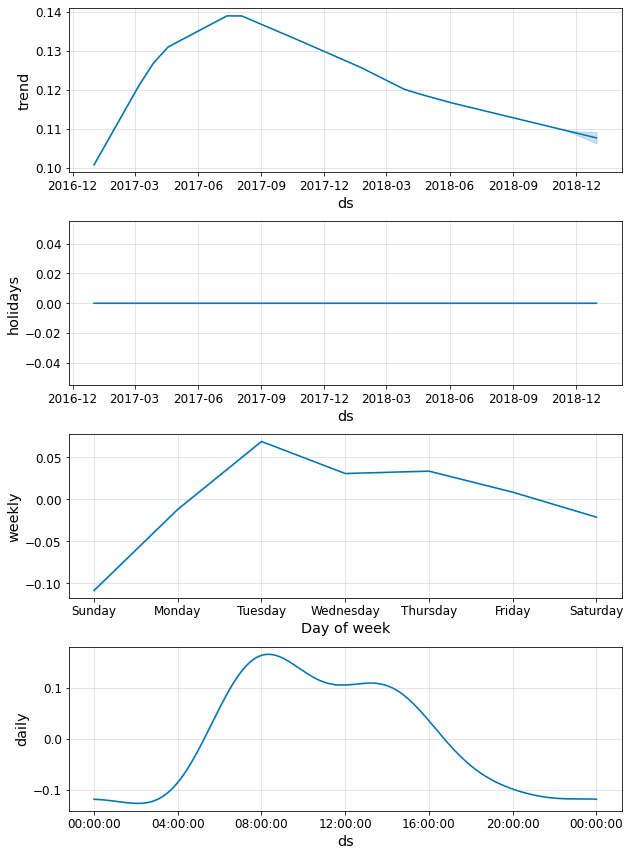

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


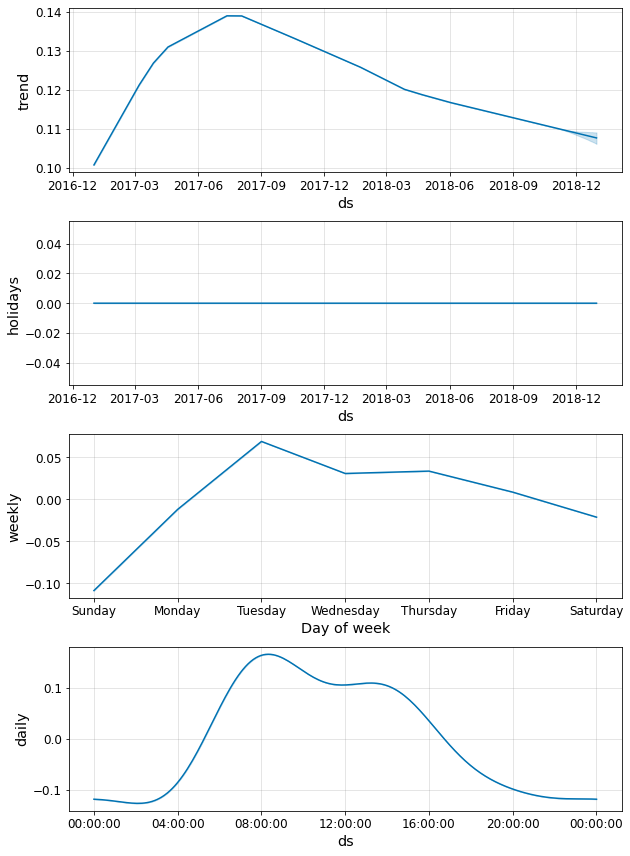

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing NV
Analyzing THE LAW minifirm
Traditional


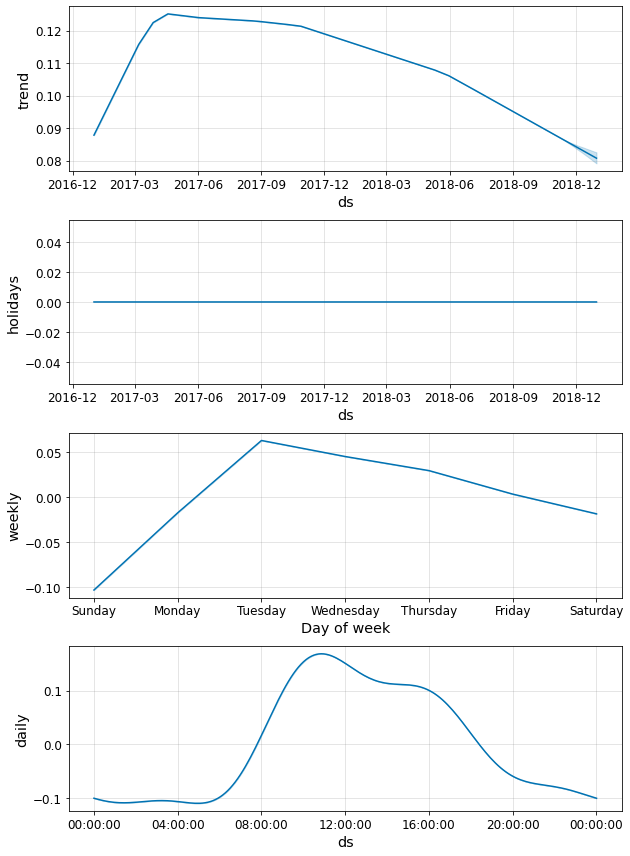

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


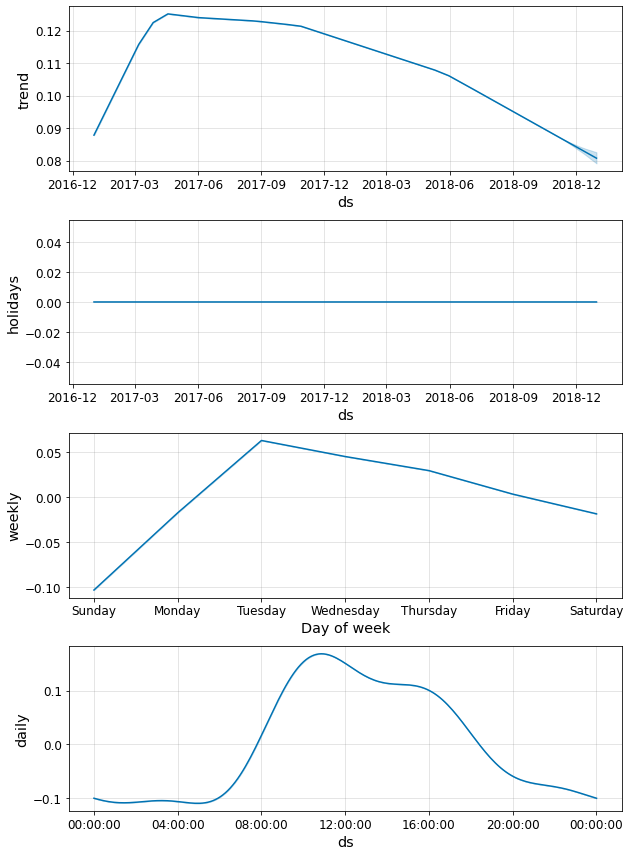

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing IL
Analyzing THE LAW minifirm
Traditional


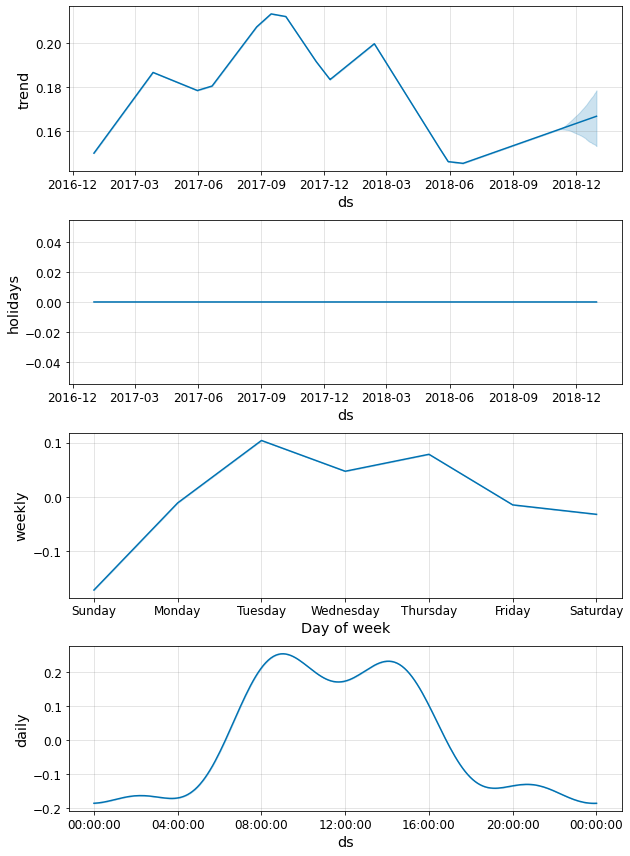

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


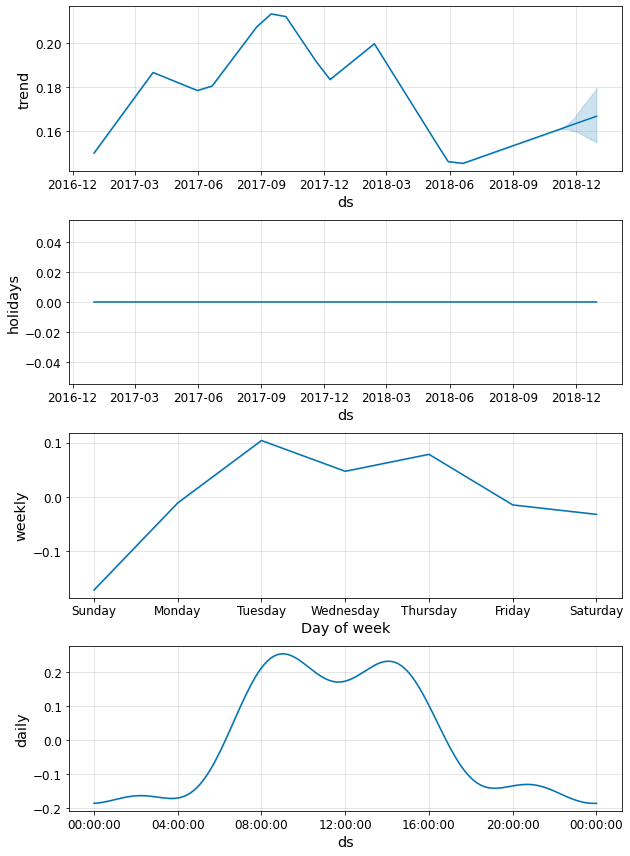

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing MO
Analyzing THE LAW minifirm
Traditional


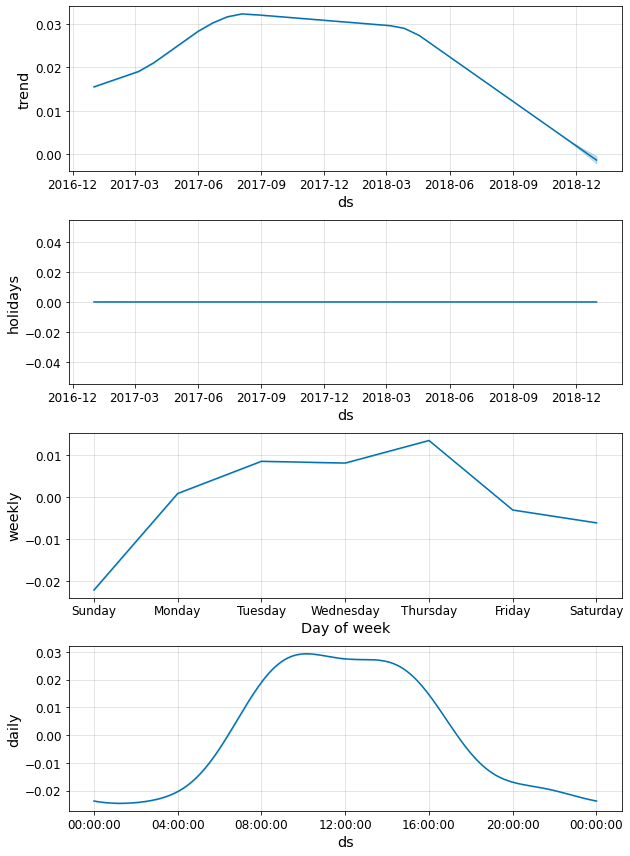

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


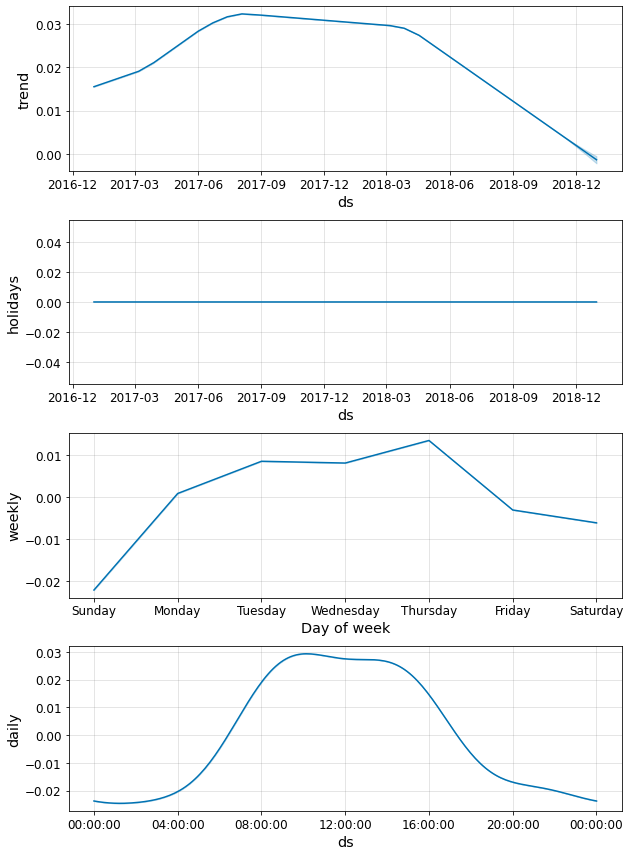

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing KY
Analyzing THE LAW minifirm
Traditional


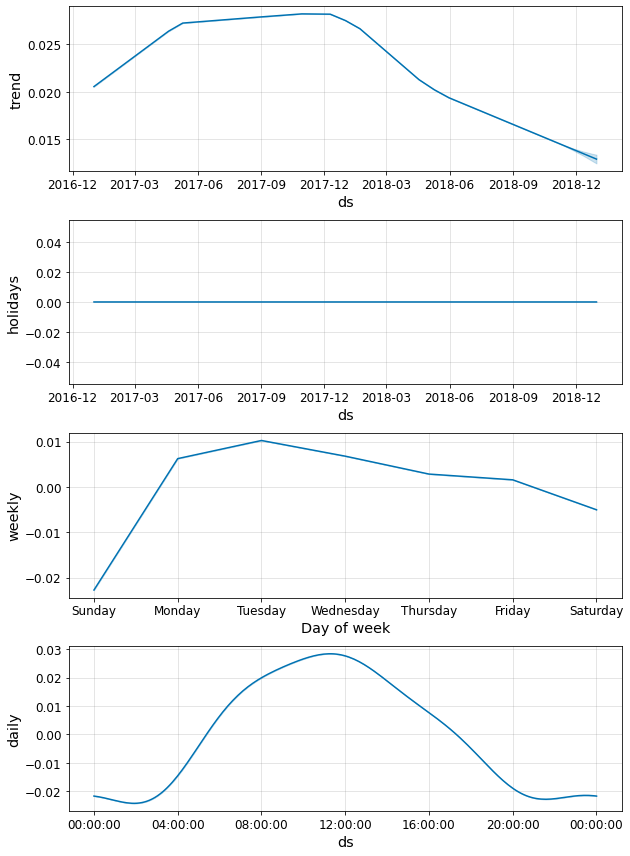

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


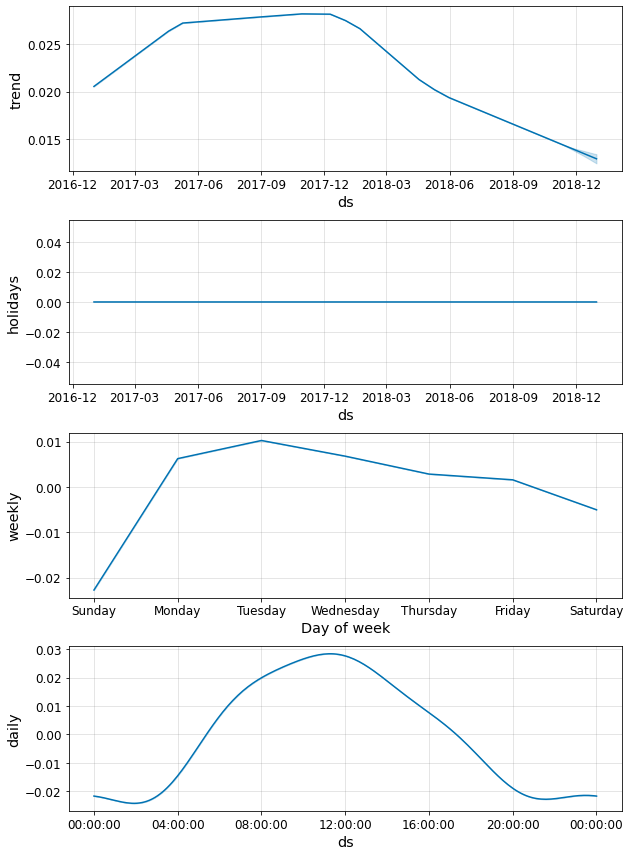

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing WI
Analyzing THE LAW minifirm
Traditional


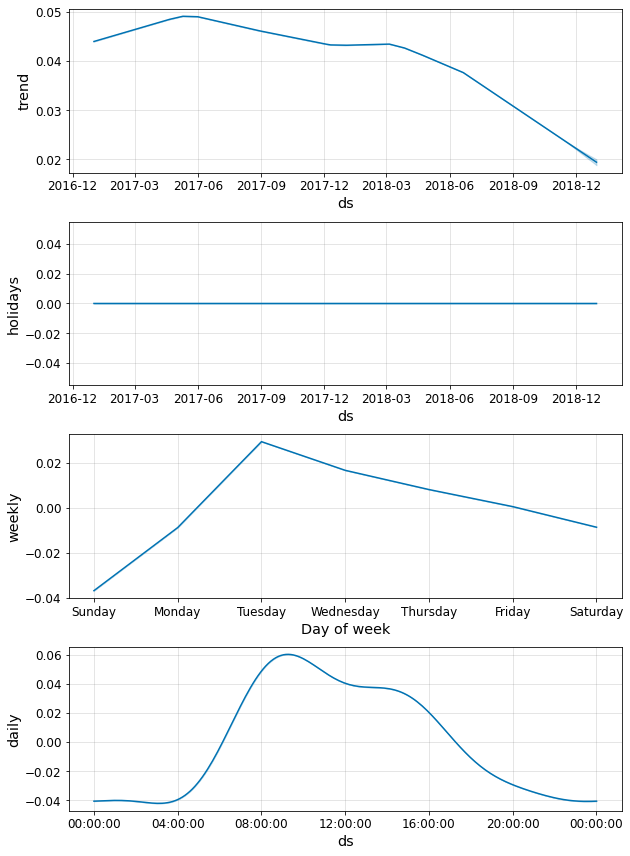

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


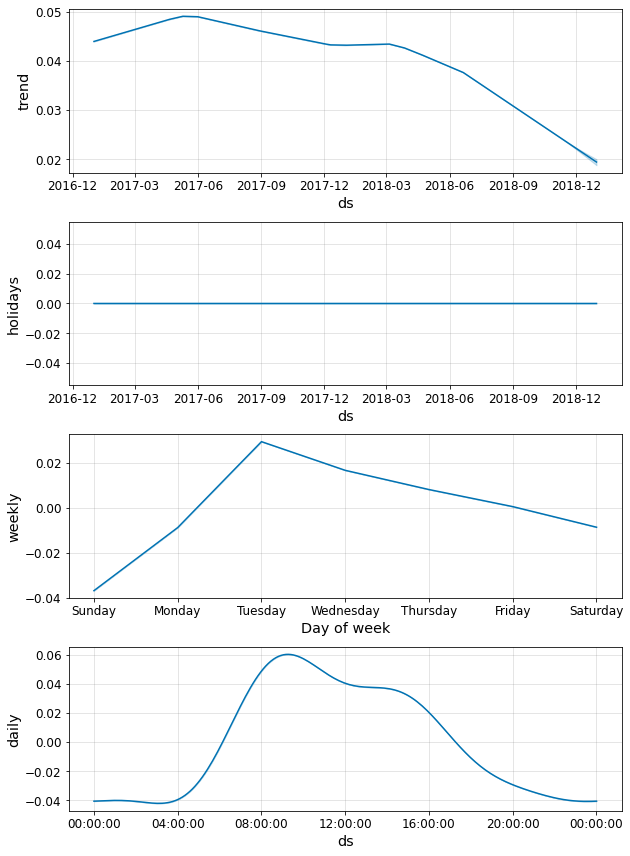

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing CT
Analyzing THE LAW minifirm
Traditional


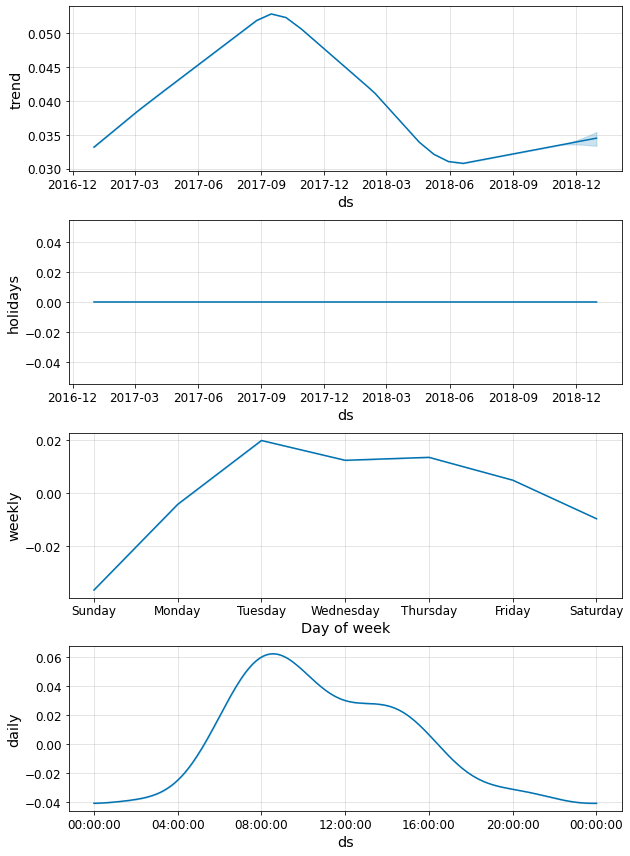

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


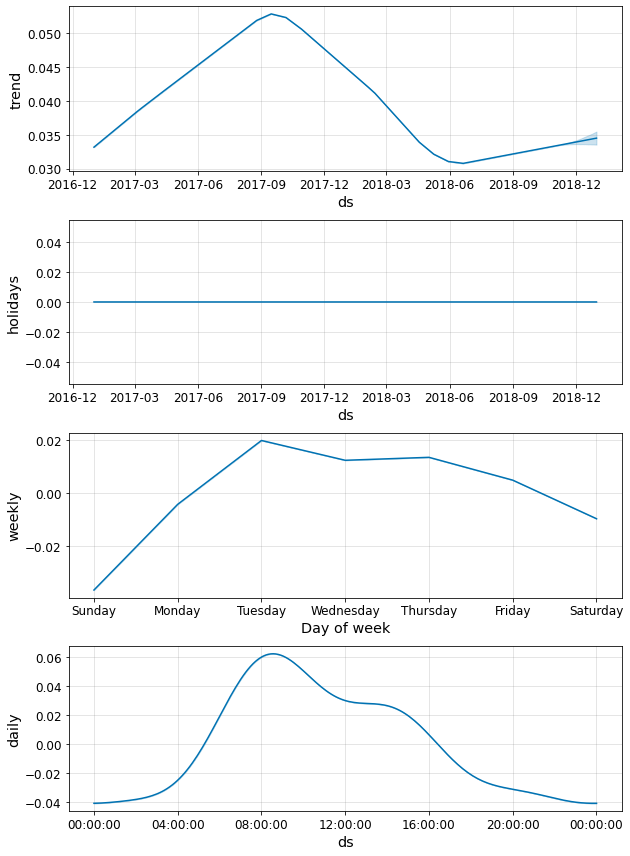

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing OH
Analyzing THE LAW minifirm
Traditional


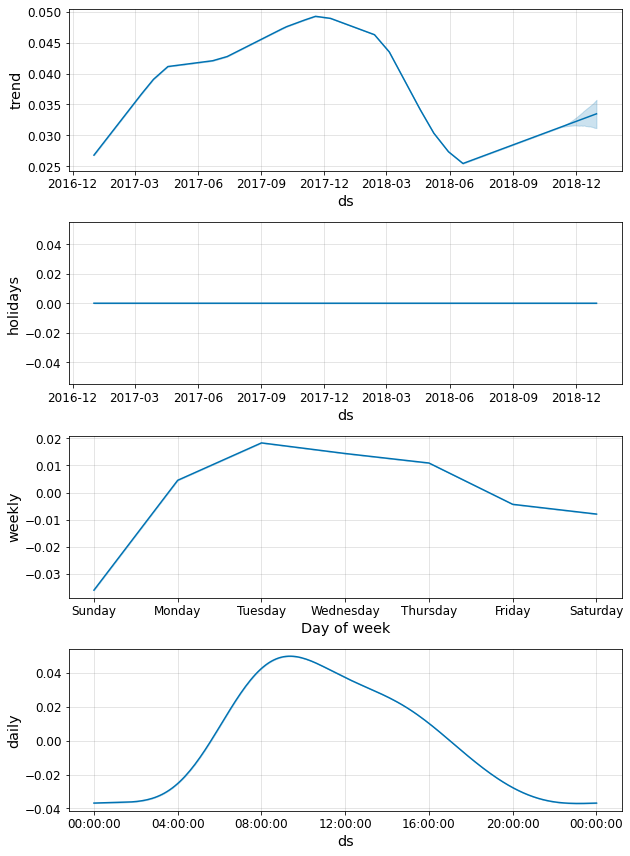

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


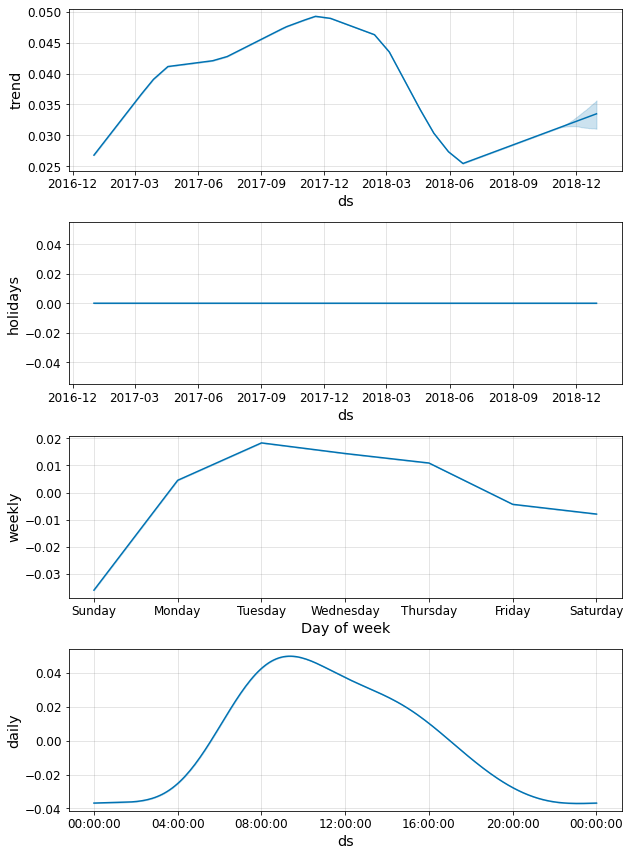

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing MS
Analyzing THE LAW minifirm
Traditional


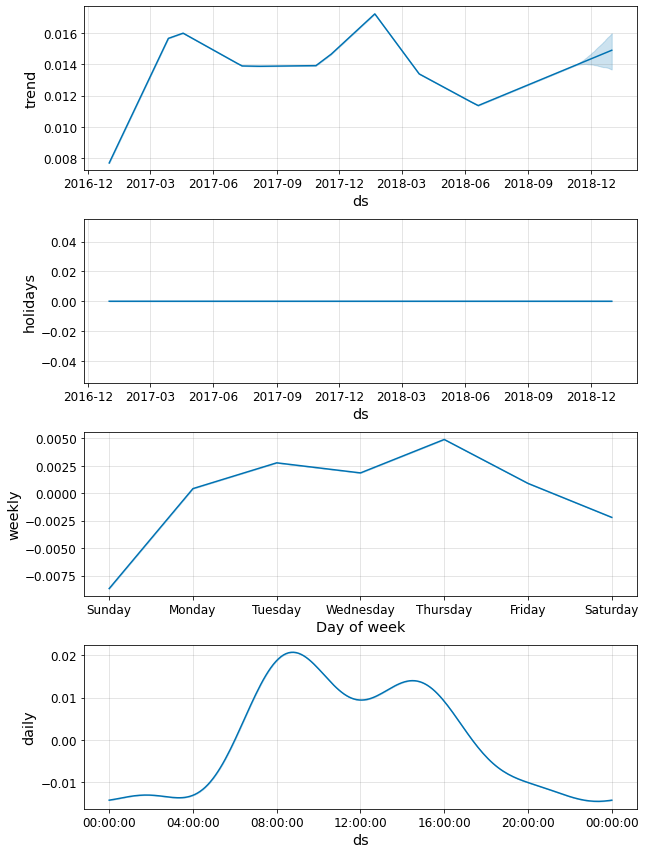

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


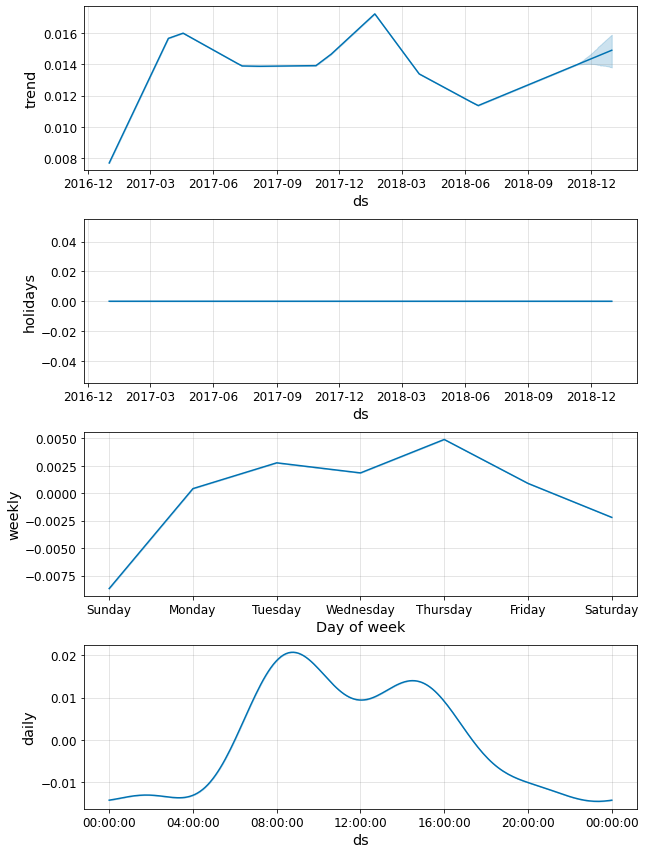

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing RI
Analyzing THE LAW minifirm
Traditional


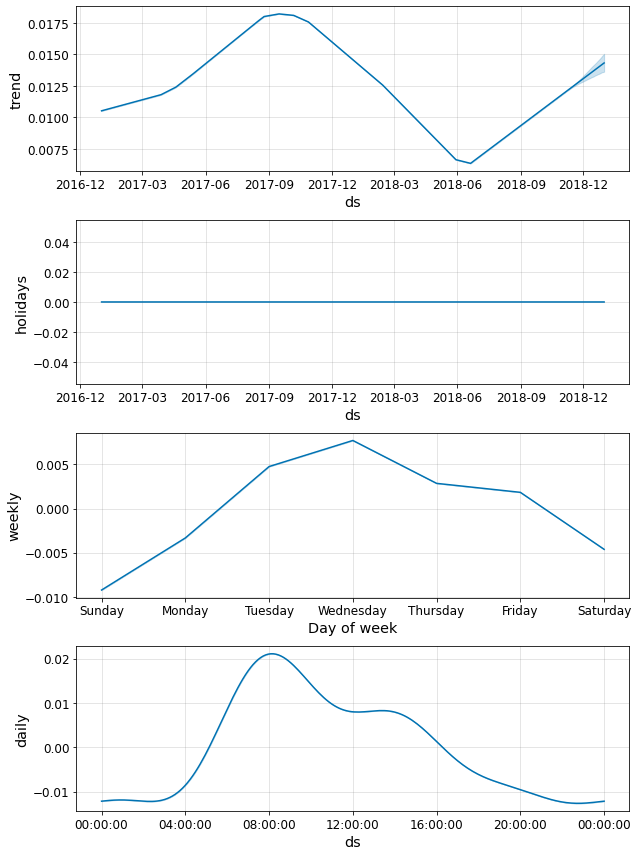

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


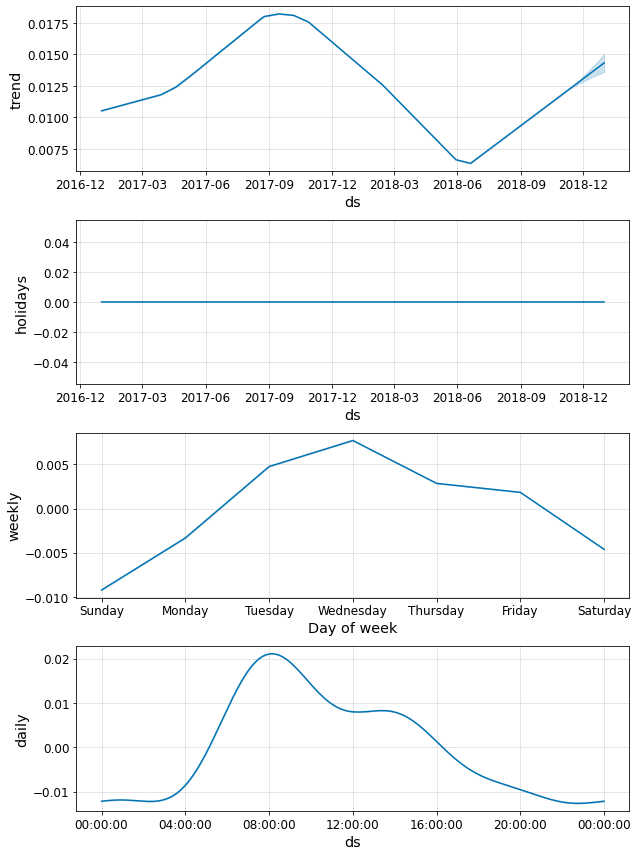

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing MN
Analyzing THE LAW minifirm
Traditional


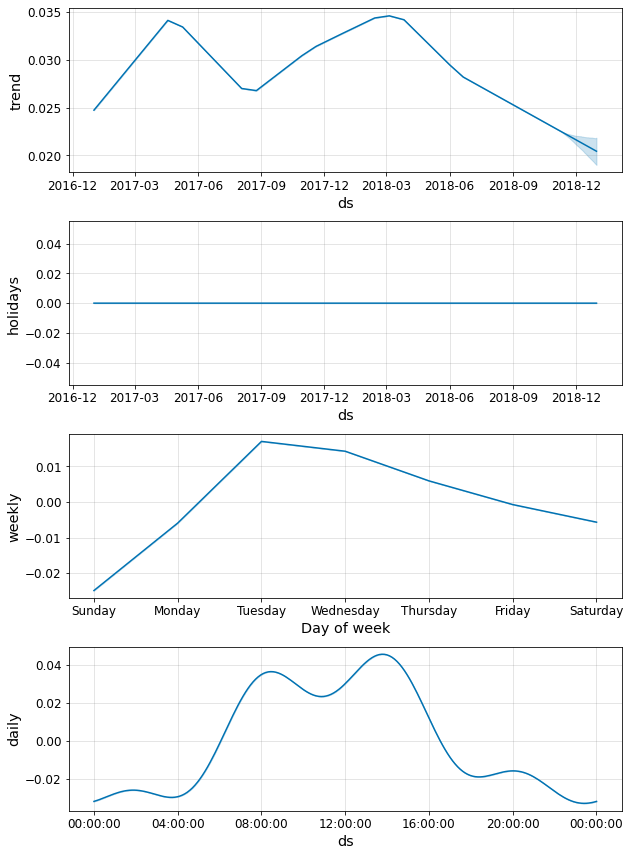

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


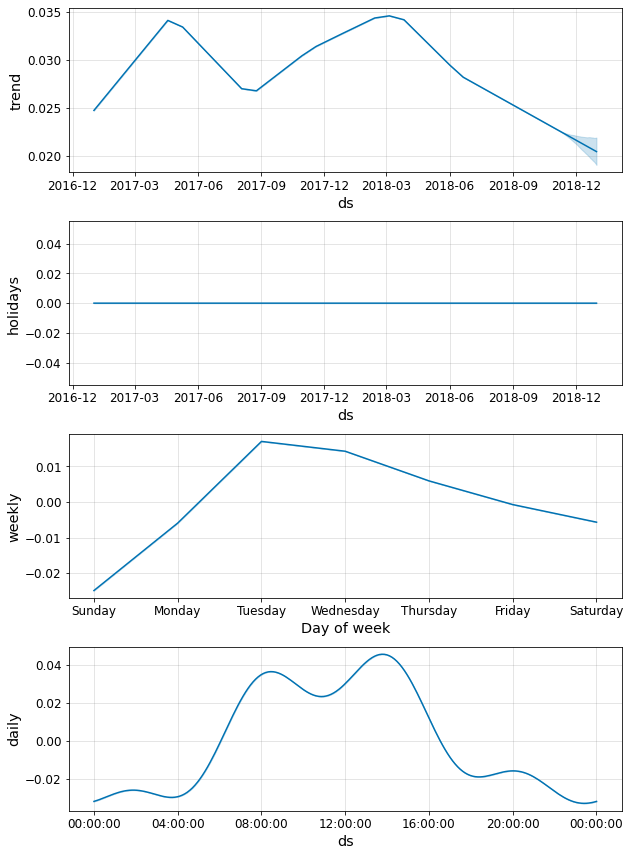

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing MA
Analyzing THE LAW minifirm
Traditional


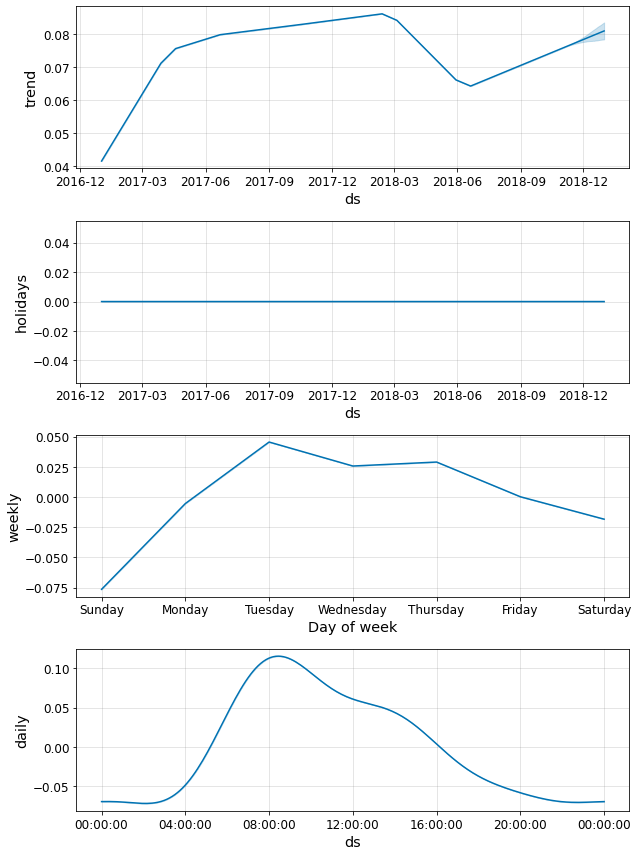

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


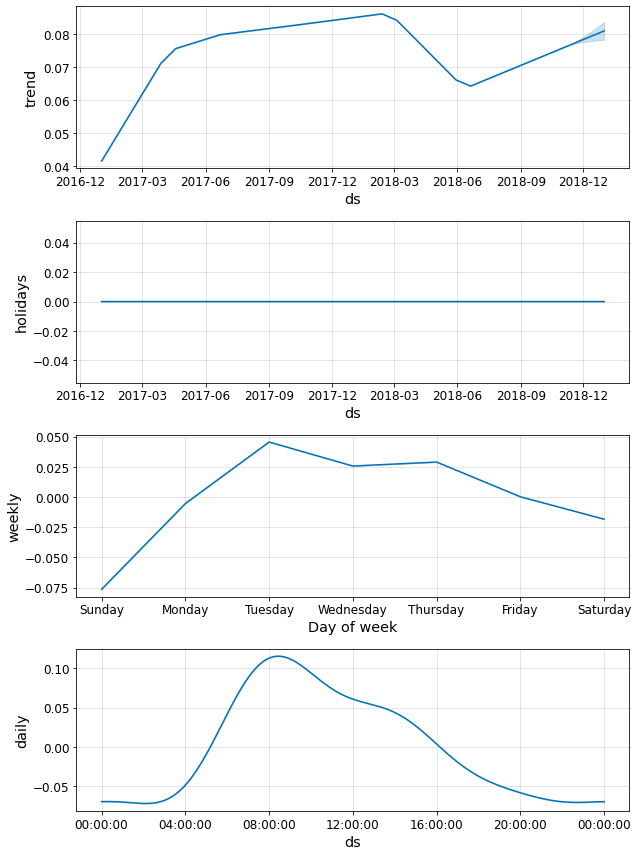

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing SC
Analyzing THE LAW minifirm
Traditional


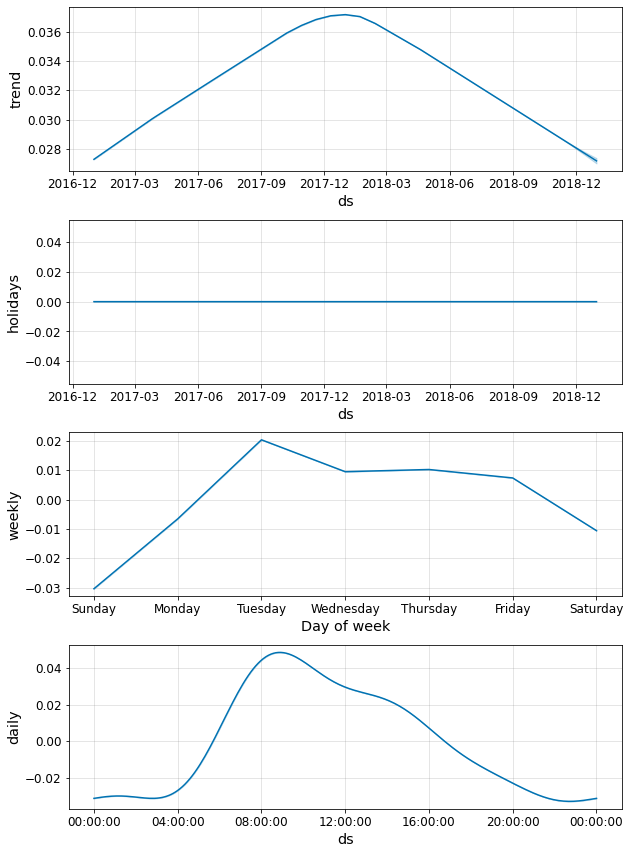

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


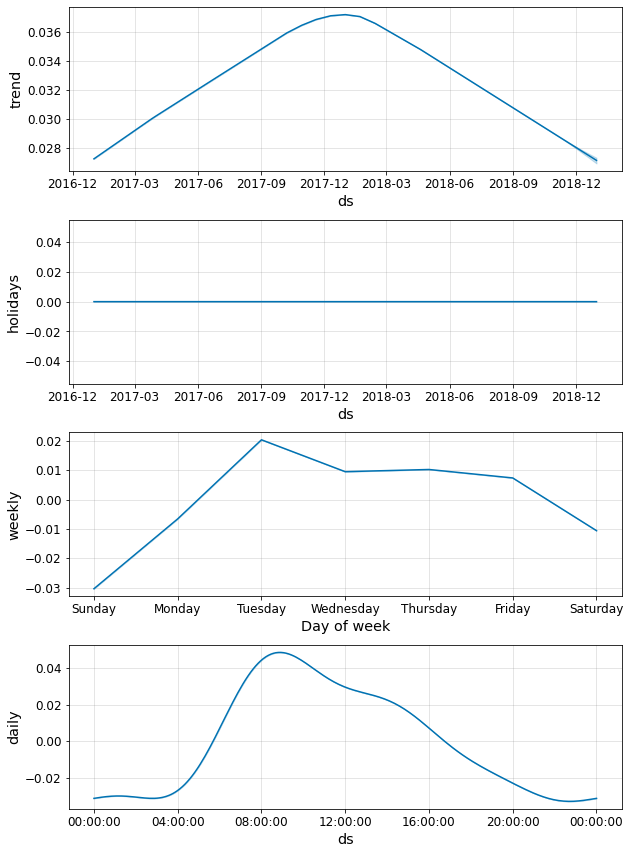

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing UT
Analyzing THE LAW minifirm
Traditional


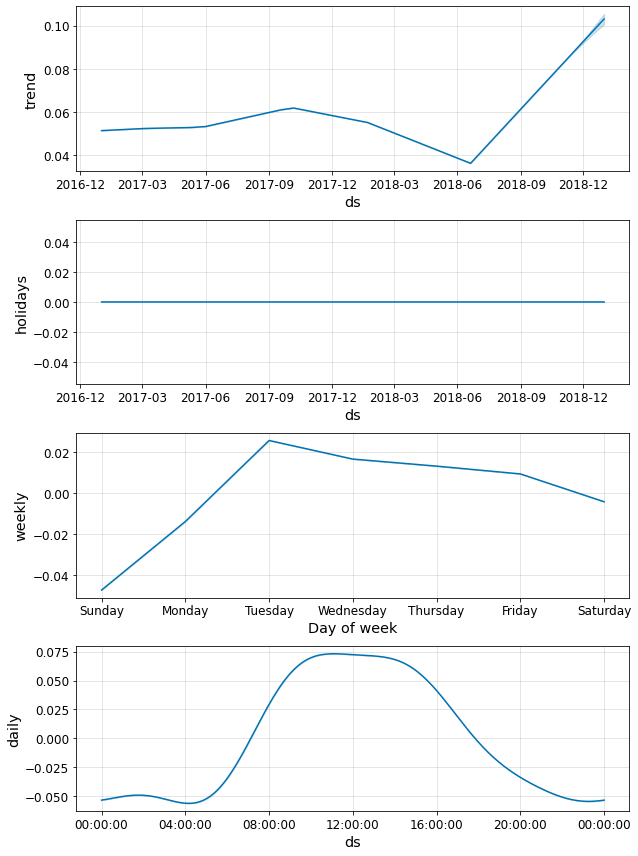

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


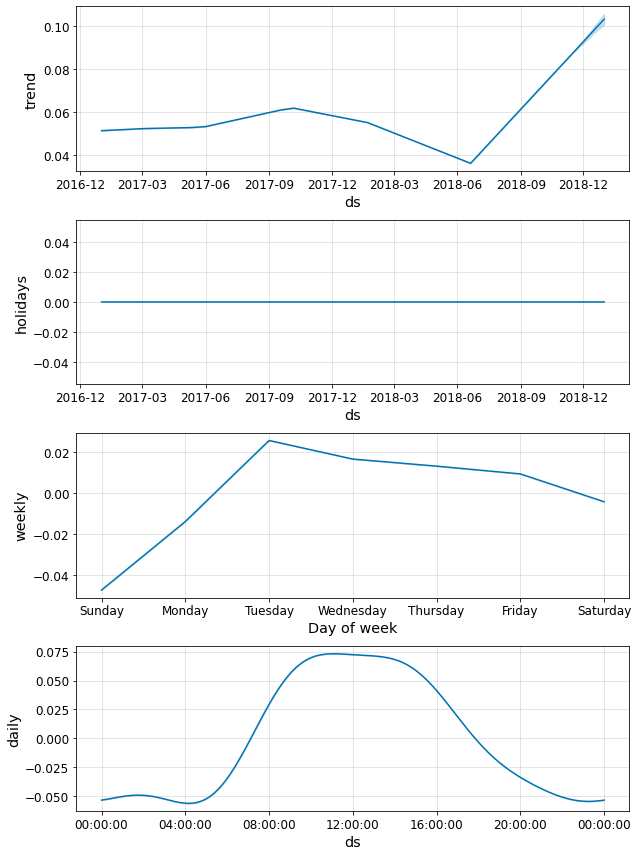

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing MI
Analyzing THE LAW minifirm
Traditional


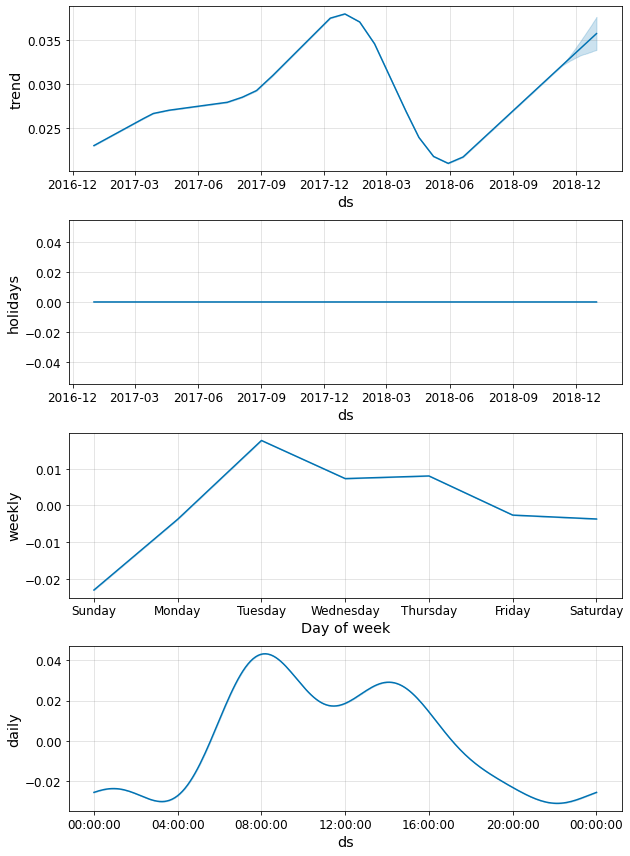

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing THE LAW minifirm
Digital


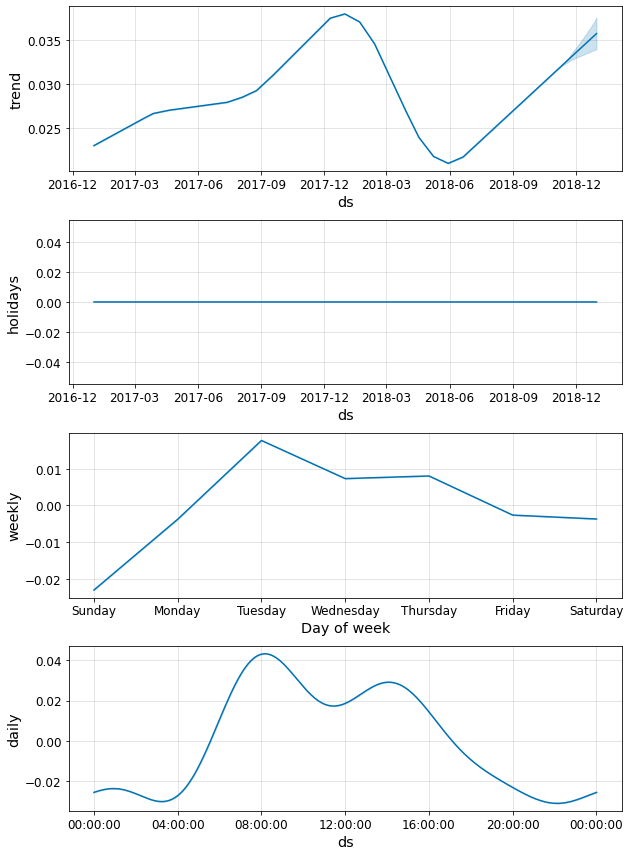

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Analyzing AR
Analyzing THE LAW minifirm
Traditional


In [ ]:
#Defined above
# df_calls_TL2 = df_calls.loc[df_calls['CompanyShortName'] == 'TL2'].copy()
# df_calls_LD = df_calls.loc[df_calls['CompanyShortName'] != 'TL2'].copy()

df_arr= [df_calls_LD, df_calls_TL2]
z=1
l=1


for df in df_arr:
    if z == 1:
        name = "THE LAW"
        z+=1
    else : 
        name = "Los Defensores"
    
    for loc in df['State'].unique(): 
        print("Analyzing " + loc)
        
#         df_loc.loc[df['State'] == loc].copy()
        
        for media in uniqueValues:
            if (media != np.nan):
                print("Analyzing "+name+" minifirm")
                print (media)
                cop = df.loc[df['MediaGroup'] == media].copy()
                copy = df.loc[df['State'] == loc].copy()
                copy['StartTime'] = pd.to_datetime(copy['StartTime'])
                # training_cutoff = pd.to_datetime('2018-11-1 00:00:00')
                copy['StartTimeHourly'] = copy['StartTime'].apply(lambda dt: dt.replace(minute=0))
                copy.groupby(['StartTimeHourly'])['CallId'].count()
                df_grouped_hourly = copy.groupby(['StartTimeHourly'])['CallId'].count()

                ts_hourly = pd.DataFrame({'ds': dates, 'y': np.zeros(len(dates))})
                ts_hourly = ts_hourly.set_index('ds')
                ts_hourly['y'].loc[df_grouped_hourly.index] = df_grouped_hourly
                ts_hourly = ts_hourly.reset_index()
                ts_hourly_train = ts_hourly.loc[ts_hourly['ds'] < training_cutoff].copy()
                ts_hourly_test = ts_hourly.loc[ts_hourly['ds'] >= training_cutoff].copy()
                # len(ts_hourly_train)
                # len(ts_hourly_test)
                x = Prophet()
                x.add_country_holidays(country_name='US')
                x.fit(ts_hourly_train)

                future = x.make_future_dataframe(periods=24*60, freq='H')
                forecast = x.predict(future)
                z=x.plot_components(forecast)
                plt.show()
                z.savefig(name + "_"+loc+"_" + media + ".png")
                accuracy(ts_hourly_test['y'], forecast.loc[forecast['ds'] >= training_cutoff]['yhat'])